## 1. Install libraries
First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [9]:
#!conda install -n .conda ipykernel --update-deps --force-reinstall
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
%pip install -r requirements.txt

  Cloning https://github.com/AllStarsAT/starvers.git to c:\users\levi\appdata\local\temp\pip-install-rjrbjozp\starvers_ba0488643fcc4924bec1a132a7ec802d
  Resolved https://github.com/AllStarsAT/starvers.git to commit 5e6e112e2b37cb5a27af9585bd572d27187ef735
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/AllStarsAT/starvers.git 'C:\Users\Levi\AppData\Local\Temp\pip-install-rjrbjozp\starvers_ba0488643fcc4924bec1a132a7ec802d'

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine
import uuid
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, average_precision_score, matthews_corrcoef, balanced_accuracy_score, recall_score, make_scorer
from itertools import product
from sklearn.model_selection import ParameterGrid
import joblib
from tqdm.notebook import tqdm
import math

## 2. Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [11]:
#executed_by ='stud-id_12307565'
executed_by = 'stud-id_12340246'   

Set your group and student IDs. Do this only once.

In [12]:
# group id for this project
group_id = '009'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12307565'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12340246'  # Replace the digits after "id_" with student B's student ID

In [13]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [14]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

In [15]:
# For a consistent connection to server

import time
time.tzname = ('Europe/Vienna', 'Europe/Vienna')

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [16]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [17]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [18]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Liliana" .',
f':{student_a} foaf:familyName "Sulyok" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12307565"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Zita Dorina" .',
f':{student_b} foaf:familyName "Marton" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12340246"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


#engine.insert(reigstration_triples_a, prefixes=prefixes)
#engine.insert(reigstration_triples_b, prefixes=prefixes)
#engine.insert(role_triples, prefixes=prefixes)

In [19]:
# UUIDs will be generated for each data processing step, and entered manually

str(uuid.uuid4())

'61ca2985-0d46-4575-8905-96baa1b851de'

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

## 3. Business Understanding 

In [20]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [21]:
data_src_and_scenario_comment = """
The dataset is the Online Shoppers Purchasing Intention Dataset from the 
UCI Machine Learning Repository. It contains 12,330 anonymized, unique user
sessions from an e-commerce website collected over one year. The detaset 
includes behavioral, technical, and user-related attributes such as page
duration, bounce rates, visitor type. The binary target variable indicates 
whether a session resulted in revenue. 

Business Scenario:
We assume the role of data scientists for a mid-sized online retail company
that seeks to improve its marketing efficiency by identifing sessions with high
purchase intent in real time. This allows the marketing team to apply targeted
interventions (such as live chat support or limited-time discount pop-ups 
specifically for users likely to purchase) only when beneficial. 
Predicting purchase likelihood enables cost-efficient personalization, 
optimizing marketing resources and strategic decision-making
"""

business_objectives_comment = """
Primary Objective:
Increase online revenue by identifying sessions with high purchase intent and 
by proactively engaging customers using targeted, cost-efficient interventions 
that increase the probability of conversion.

Secondary Objectives:
Improve the overall conversion rate through real-time personalization.
Reduce unnecessary promotional costs on users who are highly unlikely to buy
regardless of incentives.
"""

business_success_criteria_comment = """
The project is considered a success if the resulting model can be deployed to:

Profitability: Identify purchasing customers with sufficient precision that the 
cost of the intervention (e.g., the discount margin lost) is outweighed by the 
revenue gained from "saved" sales.

Deployment Feasibility: The model must be lightweight enough to infer intent in
near real-time (milliseconds) as the user browses.
"""

data_mining_goals_comment = """
Primary Data Mining Goal: Binary Classification
Develop a supervised machine learning model to predict the target variable 
Revenue and estimates the likelihood that a given web session will result in 
a purchase.


Secondary Goal: Imbalance Management
The dataset is imbalanced (approx. 85% negative / 15% positive), therefore the
goal is to handle this skew effectively without biasing the model toward the 
majority class (No Purchase).
"""

data_mining_success_criteria_comment = """
Model-level performance targets

AUC-ROC Score: 
Achieving a score greater than 0.80 on the test set, indicating a strong 
ability to distinguish between buyers and non-buyers.

F1-Score: 
Achieving a score greater than 0.50, which is the current state-of-the-art
baseline result.

Baseline Comparison:
The model must significantly outperform a trivial classifier (which would 
achieve ~85% accuracy by always predicting "No Purchase") and a random guess 
baseline.

Stable performance across validation splits.
"""

ai_risk_aspects_comment = """
Key AI risk considerations:

1. Bias and Fairness:
The dataset contains features such as browser, operating system, and region, 
which may act as proxies for socioeconomic status, potentially leading to unfair
treatment across user groups. Class imbalance may also bias predictions towards 
the majority class.

2. Privacy and Profiling:
The analysis uses tracking data (Operating Systems, Browser, Duration). 
Deployment requires strict adherence to privacy regulations (e.g., GDPR), 
ensuring users have consented to behavioral tracking, knowing that bhavioral 
data may enable profiling of users.

3. Transparency:
If personalized offers are triggered based on model predictions, stakeholders 
must be able to understand and justify the reasoning behind these decisions.

4. Operational Risk:
Incorrect predictions may lead to unnecessary promotion costs (false positives)
or missed revenue opportunities (false negatives). 
Thresholding and monitoring must be carefully designed.

5. Manipulation:
There is an ethical risk in exploiting behavioral data to target vulnerable
users with aggressive sales tactics.
"""



business_understanding_uuid_executor = '53996d94-9b75-4479-9046-e15a53067259' #generated, do not modify
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .',
f':business_understanding prov:qualifiedAssociation :{business_understanding_uuid_executor} .',
f':{business_understanding_uuid_executor} prov:agent :{executed_by} .',
f':{business_understanding_uuid_executor} rdf:type prov:Association .',
f':{business_understanding_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

### Load data

In [22]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(data_understanding_phase_executor, prefixes=prefixes)


In [23]:
load_shopping_data_code_writer = student_a

def load_shopping_data(filepath: str)-> pd.DataFrame:
    """
    Load the online shoppers purchasing intention dataset from a CSV file.
    The nature of the data requires no index set.

    Returns:
        pd.DataFrame: DataFrame containing the loaded dataset.
    """
    
    raw_data = pd.read_csv(shopping_data_path,  sep=',', header = 0)
    # Check for invalid month values, and convert to date type
    valid_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    raw_data['Month'] = raw_data['Month'].apply(lambda x: next(
        (month for month in valid_months if month in x), None) 
        if isinstance(x, str) else None)
    raw_data['Month'] = pd.to_datetime(raw_data['Month'], format='%b', 
                                       errors='coerce').dt.month

    # Convert textual categories to numerical categories
    visitor_type_mapping = {
    'Returning_Visitor': 1,
    'New_Visitor': 2,
    'Other': 3
    }

    raw_data['VisitorType'] = raw_data['VisitorType'].map(visitor_type_mapping)
    raw_data['VisitorType'] = raw_data['VisitorType'].fillna(3).astype(int)

    return raw_data



start_time_ld = now()
shopping_data_path = os.path.join("data", "online_shoppers_intention.csv")
shopping_df = load_shopping_data(shopping_data_path)
end_time_ld = now()

display(shopping_df.head())


#############################################
# Documentation
#############################################

ld_ass_uuid_executor = "fa0f4ddf-4a31-40bd-b2a0-98146b8f2de5" #generated, do not modify
load_shopping_data_executor = [
    f':load_shopping_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
#engine.insert(load_shopping_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "8fc07fd5-de82-4b44-a7b7-ecafc0fdbe09" #generated, do not modify
ld_report = """
Load all records of the shopping dataset. The activity reads the CSV file,
converts the Month attribute to a machine-readable textual representation,
converts the Visitor type attribute to numerical categories, and 
returns a dataframe containing 18 semantically interpretable fields.
"""
load_shopping_data_activity = [
    ':load_shopping_data rdf:type prov:Activity .',
    ':load_shopping_data sc:isPartOf :data_understanding_phase .',
    ':load_shopping_data rdfs:comment \'Data Understanding\' .',
    f':load_shopping_data rdfs:comment """{ld_report}""" .', 
    f':load_shopping_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_shopping_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',

    #Writer association
    f':load_shopping_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_shopping_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # INPUT of activity
    ':load_shopping_data prov:used :raw_data .',
    ':load_shopping_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',

    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_shopping_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
#engine.insert(load_shopping_data_activity, prefixes=prefixes)

# Description of the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Online Shoppers Purchasing Intention Dataset\' .',
    ':raw_data sc:description \'Describe the data set.\' .',

    # The dataset
    ':online_shoppers_intention_csv rdf:type cr:FileObject .',
    ':online_shoppers_intention_csv sc:name \'online_shoppers_intention.csv\' .',
    ':online_shoppers_intention_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :online_shoppers_intention_csv .',

    # Distribution 
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table of online shopping sessions over a year\' .',
    ':raw_recordset cr:source :online_shoppers_intention_csv .',
    ':raw_data cr:recordSet :raw_recordset .'
]
#engine.insert(raw_data_triples, prefixes=prefixes)

# Description of all the fields in the dataset using Croissant
fields = {
    "Administrative": ("Number of administrative pages visited.", "xsd:integer"),
    "Administrative_Duration": ("Time spent on administrative pages (sec).", "xsd:double"),
    "Informational": ("Number of informational pages visited.", "xsd:integer"),
    "Informational_Duration": ("Time spent on informational pages (sec).", "xsd:double"),
    "ProductRelated": ("Number of product-related pages viewed.", "xsd:integer"),
    "ProductRelated_Duration": ("Total time on product pages (sec).", "xsd:double"),
    "BounceRates": ("Average bounce rate.", "xsd:double"),
    "ExitRates": ("Average exit rate.", "xsd:double"),
    "PageValues": ("Average value a user visited before completing a transaction.", "xsd:double"),
    "SpecialDay": ("Proximity to a special day (0–1).", "xsd:double"),
    "Month": ("Month of session.", "xsd:string"),
    "OperatingSystems": ("Operating system code.", "xsd:integer"),
    "Browser": ("Browser code.", "xsd:integer"),
    "Region": ("Region code.", "xsd:integer"),
    "TrafficType": ("Traffic source category.", "xsd:integer"),
    "VisitorType": ("Returning or new visitor.", "xsd:string"),
    "Weekend": ("Boolean indicating weekend visit.", "xsd:boolean"),
    "Revenue": ("Class label: whether purchase occurred.", "xsd:boolean")
}


field_triples = []
for field_name, (desc, datatype) in fields.items():
    field_id = f":field_{field_name}"
    field_triples += [
        f'{field_id} rdf:type cr:Field .',
        f'{field_id} sc:name "{field_name}" .',
        f'{field_id} sc:description "{desc}" .',
        f'{field_id} cr:dataType {datatype} .',
        f':raw_recordset cr:field {field_id} .',
    ]

#engine.insert(field_triples, prefixes=prefixes)

units_triples = [
    # page counts = arbitrary count unit
    ':field_Administrative qudt:unit qudt:CountingUnit .',
    ':field_Informational qudt:unit qudt:CountingUnit .',
    ':field_ProductRelated qudt:unit qudt:CountingUnit .',

    # durations = seconds
    ':field_Administrative_Duration qudt:unit siu:second .',
    ':field_Informational_Duration qudt:unit siu:second .',
    ':field_ProductRelated_Duration qudt:unit siu:second .',

    # bounce, exit, special day, page values = dimensionless ratios
    ':field_BounceRates qudt:unit qudt:DimensionlessUnit .',
    ':field_ExitRates qudt:unit qudt:DimensionlessUnit .',
    ':field_SpecialDay qudt:unit qudt:DimensionlessUnit .',
    ':field_PageValues qudt:unit qudt:DimensionlessUnit .',

    # categorical / boolean: no units needed
]

#engine.insert(units_triples, prefixes=prefixes)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,1,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,1,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,1,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,1,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,1,True,False


### 2.a Attribute types, units of measurement, and the semantics of attributes

In [24]:
data_understanding_2a_code_writer = student_a


def data_understanding_2a():
    """
    Perform initial data exploration and understanding of the shopping dataset.
    Generates summary statistics and inspects data types.

    Returns:
        None
    """


    display(shopping_df.info())
    ## CONCLUSIONS:
    # - Number of rows and columns is correct.
    # - Semantically, all data types appear correct; object-type columns require closer inspection.
    # - Non-null counts look correct; NA types still need deeper evaluation.


    display(shopping_df.describe())
    ## CONCLUSIONS:
    # - Numerical columns show semantically meaningful ranges.
    # - Minimum/maximum values appear correct
    # - Means indicate class imbalance—skew analysis required later.
    # - No semantic outliers identified, but statistical outliers will be checked later.

    display(shopping_df.describe(include=["object", "bool"]))
    ## CONCLUSTIONS:
    # - Categorical fields have expected number of unique values
    # - Unexpected additional default visitor type will be checked later.

    display(shopping_df.nunique())
    ## CONCLUSION:
    # - The 'Month' column is missing two months; need to inspect if the dataset covers whole year.

    display(shopping_df["TrafficType"].unique())
    display(shopping_df["Month"].unique())
    display(shopping_df["OperatingSystems"].unique())
    display(shopping_df["SpecialDay"].unique())
    display(shopping_df["VisitorType"].unique())
    ## Conclusion
    # All categorical, boolean fields have expected unique values except 'VisitorType',
    # which includes an unexpected 'Other' category. The 'Month' field is missing two months.




In [25]:
start_time_data_understanding_2a = now()
data_understanding_2a()
end_time_data_understanding_2a = now()


############################################################
# 2a Documentation
############################################################

data_understanding_2a_ass_uuid_executor = "f359c376-274b-4da4-ba6b-b4e2788109f9" #generated, do not modify
data_understanding_2a_ass_uuid_writer = "96d0a477-2bca-4012-ab6e-b017a083705d" #generated, do not modify

data_understanding_2a_comment = """
Data Understanding 2a: Attribute types, semantics, units, and initial interpretation.
The dataset structure (rows, columns, dtypes) matches expectations. Numerical attributes 
reflect semantically meaningful ranges with plausible min/max values. Two attributes that expresses
percentage units has a 0.2 upper threshold that was not mentioned in the data description.
Object-typed fields require follow-up semantic validation. No semantic anomalies detected at this stage but 
statistical outlier analysis will follow. The Month attribute shows missing months -namely January and April-, 
requiring furhter investigation. VisitorType contains an unexpected 'Other' category.
"""

attribute_info = {
    "Administrative": "Number of administrative pages visited.",
    "Administrative_Duration": "Total time spent on administrative pages (seconds).",
    "Informational": "Number of informational pages visited.",
    "Informational_Duration": "Time spent on informational pages (seconds).",
    "ProductRelated": "Number of product-related pages viewed.",
    "ProductRelated_Duration": "Total time on product pages (seconds).",
    "BounceRates": "Percentage of visitors who land and leave from a page without any further interaction.",
    "ExitRates": "Percentage of last pageviews in the session.",
    "PageValues": "Average value a user visited before completing a transaction.",
    "SpecialDay": "Proximity to a special day (0–1).",
    "Month": "Month of session.",
    "OperatingSystems": "Recorded OS identifier.",
    "Browser": "Browser identifier.",
    "Region": "Region code.",
    "TrafficType": "Traffic source category.",
    "VisitorType": "Returning or new visitor.",
    "Weekend": "Boolean indicating if visit was on a weekend.",
    "Revenue": "Target variable: purchase occurred (True/False)."
}

info_output = str(shopping_df.info())
describe_numeric_output = shopping_df.describe().to_json()
describe_categorical_output = shopping_df.describe(include=["object","bool"]).to_json()
nunique_output = shopping_df.nunique().to_json()


traffic_type_unique_output = shopping_df["TrafficType"].unique().tolist()
month_unique_output = shopping_df["Month"].unique().tolist()
os_unique_output = shopping_df["OperatingSystems"].unique().tolist()
specialday_unique_output = shopping_df["SpecialDay"].unique().tolist()
visitor_unique_output = shopping_df["VisitorType"].unique().tolist()



data_understanding_2a_activity = [

    # Activity definition
    ':data_understanding_2a rdf:type prov:Activity .',
    ':data_understanding_2a sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2a rdfs:label "2a Attribute Types and Semantics" .',
    f':data_understanding_2a rdfs:comment """{data_understanding_2a_comment}""" .',

    # Timing
    f':data_understanding_2a prov:startedAtTime "{start_time_data_understanding_2a}"^^xsd:dateTime .',
    f':data_understanding_2a prov:endedAtTime "{end_time_data_understanding_2a}"^^xsd:dateTime .',

    # Executor association
    f':data_understanding_2a prov:qualifiedAssociation :{data_understanding_2a_ass_uuid_executor} .',
    f':{data_understanding_2a_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2a_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2a_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Writer association
    f':data_understanding_2a prov:qualifiedAssociation :{data_understanding_2a_ass_uuid_writer} .',
    f':{data_understanding_2a_ass_uuid_writer} prov:agent :{data_understanding_2a_code_writer} .',
    f':{data_understanding_2a_ass_uuid_writer} rdf:type prov:Association .',
    f':{data_understanding_2a_ass_uuid_writer} prov:hadRole :{code_writer_role} .',


    ### ENTITY: Attribute Semantics -----------------------------------------
    ':data_understanding_2a_attribute_info rdf:type prov:Entity .',
    ':data_understanding_2a_attribute_info rdfs:label "Attribute Semantics" .',
    f':data_understanding_2a_attribute_info rdfs:comment """{attribute_info}""" .',
    ':data_understanding_2a_attribute_info prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: shopping_df.info() -------------------------------------------
    ':data_understanding_2a_info rdf:type prov:Entity .',
    ':data_understanding_2a_info rdfs:label "DataFrame Info Output" .',
    f':data_understanding_2a_info rdfs:comment """{info_output}""" .',
    ':data_understanding_2a_info prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: shopping_df.describe() numeric summary ------------------------
    ':data_understanding_2a_describe_numeric rdf:type prov:Entity .',
    ':data_understanding_2a_describe_numeric rdfs:label "Numeric Summary Statistics" .',
    f':data_understanding_2a_describe_numeric rdfs:comment """{describe_numeric_output}""" .',
    ':data_understanding_2a_describe_numeric prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: describe() categorical summary --------------------------------
    ':data_understanding_2a_describe_categorical rdf:type prov:Entity .',
    ':data_understanding_2a_describe_categorical rdfs:label "Categorical Summary Statistics" .',
    f':data_understanding_2a_describe_categorical rdfs:comment """{describe_categorical_output}""" .',
    ':data_understanding_2a_describe_categorical prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: nunique() -----------------------------------------------------
    ':data_understanding_2a_nunique rdf:type prov:Entity .',
    ':data_understanding_2a_nunique rdfs:label "Unique Value Counts" .',
    f':data_understanding_2a_nunique rdfs:comment """{nunique_output}""" .',
    ':data_understanding_2a_nunique prov:wasGeneratedBy :data_understanding_2a .',


    ### ENTITY: Unique categorical values -------------------------------------
    ':data_understanding_2a_unique_values rdf:type prov:Entity .',
    ':data_understanding_2a_unique_values rdfs:label "Unique Values of Key Categorical Columns" .',
    f':data_understanding_2a_unique_values rdfs:comment """TrafficType: {traffic_type_unique_output}\n'
    f'Month: {month_unique_output}\n'
    f'OperatingSystems: {os_unique_output}\n'
    f'SpecialDay: {specialday_unique_output}\n'
    f'VisitorType: {visitor_unique_output}""" .',
    ':data_understanding_2a_unique_values prov:wasGeneratedBy :data_understanding_2a .',
]


engine.insert(data_understanding_2a_activity, prefixes=prefixes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  int32  
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

None

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,7.651987,2.124006,2.357097,3.147364,4.069586,1.151176
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,3.392841,0.911325,1.717277,2.401591,4.025169,0.376989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,5.000000,2.000000,2.000000,1.000000,2.000000,1.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,7.000000,2.000000,2.000000,3.000000,2.000000,1.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,11.000000,3.000000,2.000000,4.000000,4.000000,1.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,12.000000,8.000000,13.000000,9.000000,20.000000,3.000000


,Weekend,Revenue
count,12330,12330
unique,2,2
top,False,False
freq,9462,10422


Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 18, 19,
       16, 17, 20])

array([ 2,  3,  5, 10,  6,  7,  8, 11,  9, 12], dtype=int32)

array([1, 2, 4, 3, 7, 6, 8, 5])

array([0. , 0.4, 0.8, 1. , 0.2, 0.6])

array([1, 2, 3])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  int32  
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

### 2.b Statistical properties describing the dataset including correlations

In [26]:
shopping_df.kurtosis()
### Conclusions
# ProductRelated_Duration (137.17), PageValues (65.64), Administrative_Duration (50.56) are significantly high values, which means these have long tails probably caused by very few outlier observations.
# The outliers will be checked for further analysis.

Administrative               4.701146
Administrative_Duration     50.556739
Informational               26.932266
Informational_Duration      76.316853
ProductRelated              31.211707
ProductRelated_Duration    137.174164
BounceRates                  7.723159
ExitRates                    4.017035
PageValues                  65.635694
SpecialDay                   9.913659
Month                       -1.615746
OperatingSystems            10.456843
Browser                     12.746733
Region                      -0.148680
TrafficType                  3.479711
VisitorType                  4.544444
Weekend                     -0.397404
Revenue                      1.646493
dtype: float64

In [27]:
shopping_df.skew()

## Conclusions
# The attributes Month and Region are nearly symmetric, as their skew value is the closest to 0. This gives a hypothethis that the records are uniformly 
# or evenly distributed throughout the dataset, which might mean that there is a balanced record set, with no temporal or regional bias.
# All the duration attributes have high skew values, which could be expected, and will be furhter checked for their outlier distributions.
# The positive value of the target of Revenue shows right-skewed distribution, that imbalanced classes.

Administrative             1.960357
Administrative_Duration    5.615719
Informational              4.036464
Informational_Duration     7.579185
ProductRelated             4.341516
ProductRelated_Duration    7.263228
BounceRates                2.947855
ExitRates                  2.148789
PageValues                 6.382964
SpecialDay                 3.302667
Month                     -0.055407
OperatingSystems           2.066285
Browser                    3.242350
Region                     0.983549
TrafficType                1.962987
VisitorType                2.326762
Weekend                    1.265962
Revenue                    1.909509
dtype: float64

<Axes: >

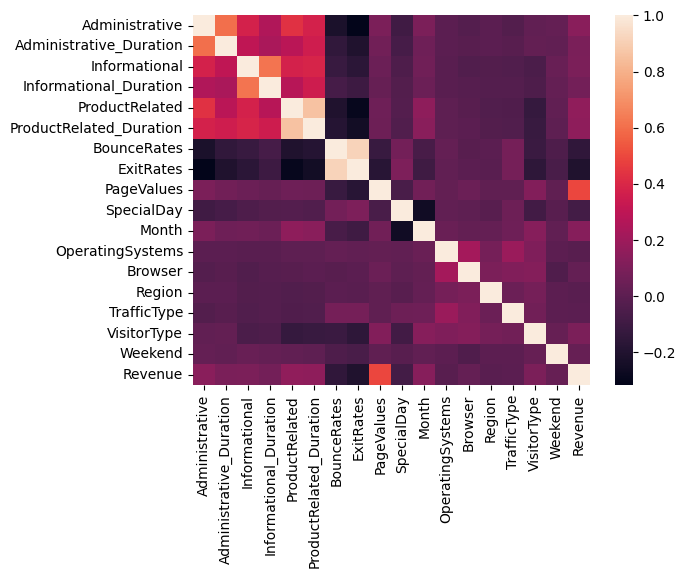

In [28]:
sns.heatmap(shopping_df.corr(numeric_only=True))

<Axes: >

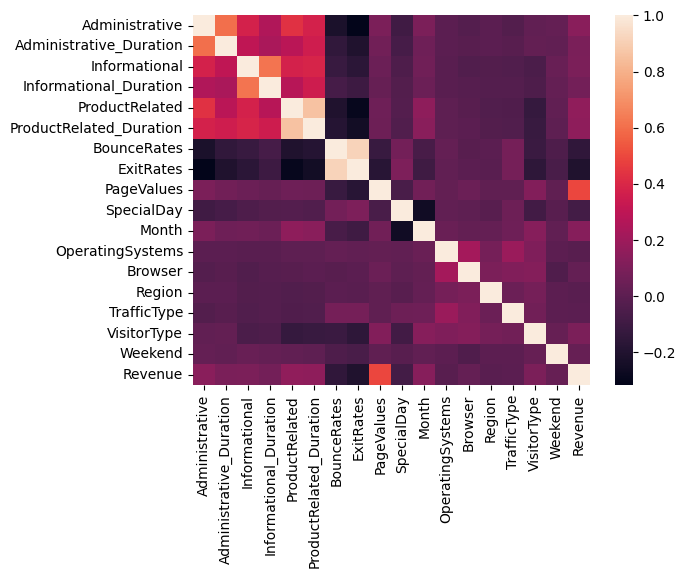

In [29]:
sns.heatmap(shopping_df.corr(method='pearson'))

<Axes: >

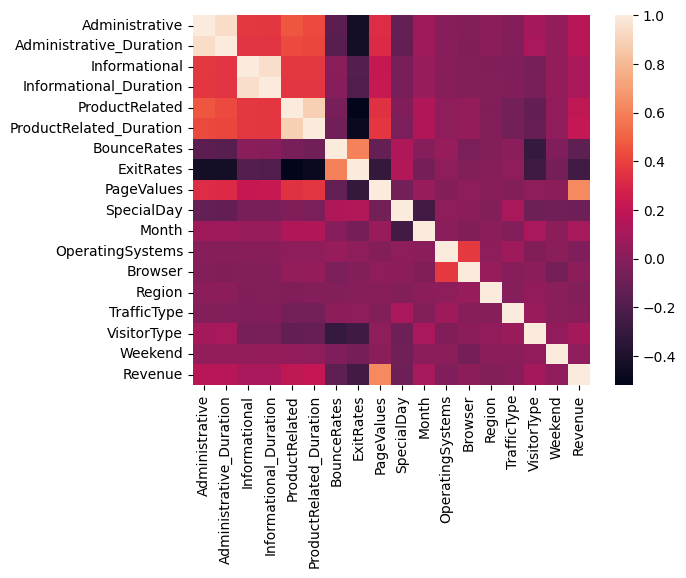

In [30]:
sns.heatmap(shopping_df.corr(method='spearman'))

In [31]:
data_understanding_2b_code_writer = student_a

def data_understanding_2b():
    kurtosis_series = shopping_df.kurtosis(numeric_only=True)
    skew_series = shopping_df.skew(numeric_only=True)
    pearson_corr = shopping_df.corr(method="pearson", numeric_only=True)
    spearman_corr = shopping_df.corr(method="spearman", numeric_only=True)

    # --- Correlation heatmaps (saved to figures/) ---
    os.makedirs("figures", exist_ok=True)

    # Pearson heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pearson_corr, annot=False, vmin=-1, vmax=1)
    plt.title("Pearson Correlation Matrix")
    pearson_heatmap_path = os.path.join("figures", "corr_pearson.png")
    pearson_heatmap_path = pearson_heatmap_path.replace("\\", "/")
    plt.tight_layout()
    plt.savefig(pearson_heatmap_path, dpi=150)
    plt.close()

    # Spearman heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(spearman_corr, annot=False, vmin=-1, vmax=1)
    plt.title("Spearman Correlation Matrix")
    spearman_heatmap_path = os.path.join("figures", "corr_spearman.png")
    spearman_heatmap_path = spearman_heatmap_path.replace("\\", "/")
    plt.tight_layout()
    plt.savefig(spearman_heatmap_path, dpi=150)
    plt.close()

    results = {
        "kurtosis": kurtosis_series.to_dict(),
        "skewness": skew_series.to_dict(),
        "pearson_correlation": pearson_corr.to_dict(),
        "spearman_correlation": spearman_corr.to_dict(),
        "pearson_heatmap_path": pearson_heatmap_path,
        "spearman_heatmap_path": spearman_heatmap_path
    }

    return results


start_time_data_understanding_2b = now()
res_du = data_understanding_2b()
end_time_data_understanding_2b = now()


############################################################
# 2b Documentation (Provenance)
############################################################

data_understanding_2b_ass_uuid_executor = "512863f2-5fab-433f-a464-735d1696c53d" #generated, do not modify
data_understanding_2b_ass_uuid_writer = "233de42e-2c58-4341-bc6a-6457646e1731" #generated, do not modify

data_understanding_2b_comment = """
Data Understanding 2b: Statistical properties and correlations.
Kurtosis and skewness were computed for all numeric attributes, revealing heavy-tailed 
distributions in several duration and value-related features, and confirming class imbalance 
for the Revenue target. Pearson and Spearman correlation matrices were computed to identify 
linear and monotonic relationships between attributes. Correlations of each feature with 
Revenue were extracted, and correlation heatmaps were generated and saved for visual 
inspection.
"""

# Serialize numeric outputs for rdfs:comment (as JSON / text)
kurtosis_output = res_du["kurtosis"]
skew_output = res_du["skewness"]
pearson_corr_output = res_du["pearson_correlation"]
spearman_corr_output = res_du["spearman_correlation"]
pearson_corr_revenue_output = res_du["pearson_correlation"]["Revenue"]
spearman_corr_revenue_output = res_du["spearman_correlation"]["Revenue"]

kurtosis_conclusions = """
ProductRelated_Duration (137.17), PageValues (65.64), and Administrative_Duration (50.56) 
show extremely high kurtosis values, indicating very heavy-tailed distributions. This means 
that a small number of observations lie far from the mean and contribute disproportionately 
to the tails. These heavy tails suggest the presence of significant outliers, which will be 
checked in later steps of the analysis.
"""

skewness_conclusions = """
The attributes Month and Region show skewness values close to zero, suggesting nearly 
symmetric distributions. This supports the hypothesis that the dataset may be well-balanced 
across temporal and regional dimensions, with no major structural bias.

All duration-based attributes exhibit strongly positive skew, which is expected because they 
represent time spent on different page types and typically include many short visits and 
fewer long visits. These high-skew attributes will require special attention during outlier 
analysis.

The target variable Revenue is positively skewed, reflecting that purchases (Revenue = 1) 
are much less frequent than non-purchases. This confirms class imbalance in the dataset.
"""

correlation_conclusions = """
Pearson and Spearman correlation matrices reveal expected positive correlations 
between PageValues and the Revenue target values. Correlations between other 
features and Revenue are generally modest. The two correlation heatmaps show
similar patterns, and matching scales.

There is a sharp decline from the very high Pearson correlation between BounceRates
and ExitRates to a lower Spearman value, which indicates that while these metrics
are linearly linked as mathematical departure counts, their relative ranks are less
synchronized. This can be caused by that many multi-page sessions have high exit 
rates on specific pages without being categorized as single-page "bounces".

Linear consistency is evident in the high coefficients for page count versus 
duration (such as Administrative vs. Administrative_Duration) across both matrices. 
This confirms that the time users spend on specific page types scales predictably 
with the number of pages they visit.
"""

data_understanding_2b_activity = [
    # Activity definition
    ':data_understanding_2b rdf:type prov:Activity .',
    ':data_understanding_2b sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2b rdfs:label "2b Statistical Properties and Correlations" .',
    f':data_understanding_2b rdfs:comment """{data_understanding_2b_comment}""" .',

    # Timing
    f':data_understanding_2b prov:startedAtTime "{start_time_data_understanding_2b}"^^xsd:dateTime .',
    f':data_understanding_2b prov:endedAtTime "{end_time_data_understanding_2b}"^^xsd:dateTime .',

    # Associations: executor
    f':data_understanding_2b prov:qualifiedAssociation :{data_understanding_2b_ass_uuid_executor} .',
    f':{data_understanding_2b_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2b_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2b_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Associations: writer
    f':data_understanding_2b prov:qualifiedAssociation :{data_understanding_2b_ass_uuid_writer} .',
    f':{data_understanding_2b_ass_uuid_writer} prov:agent :{data_understanding_2b_code_writer} .',
    f':{data_understanding_2b_ass_uuid_writer} rdf:type prov:Association .',
    f':{data_understanding_2b_ass_uuid_writer} prov:hadRole :{code_writer_role} .',


    # === Entities: Kurtosis ===
    ':data_understanding_2b_kurtosis rdf:type prov:Entity .',
    ':data_understanding_2b_kurtosis rdfs:label "Kurtosis of Numeric Attributes" .',
    f':data_understanding_2b_kurtosis rdfs:comment """Kurtosis values (JSON): {kurtosis_output}\n\n{kurtosis_conclusions}""" .',
    ':data_understanding_2b_kurtosis prov:wasGeneratedBy :data_understanding_2b .',

    # === Entities: Skewness ===
    ':data_understanding_2b_skewness rdf:type prov:Entity .',
    ':data_understanding_2b_skewness rdfs:label "Skewness of Numeric Attributes" .',
    f':data_understanding_2b_skewness rdfs:comment """Skewness values (JSON): {skew_output}\n\n{skewness_conclusions}""" .',
    ':data_understanding_2b_skewness prov:wasGeneratedBy :data_understanding_2b .',


    # === Entities: Pearson Correlation Matrix ===
    ':data_understanding_2b_pearson_corr rdf:type prov:Entity .',
    ':data_understanding_2b_pearson_corr rdfs:label "Pearson Correlation Matrix" .',
    f':data_understanding_2b_pearson_corr rdfs:comment """Pearson correlation matrix (JSON): {pearson_corr_output}""" .',
    ':data_understanding_2b_pearson_corr prov:wasGeneratedBy :data_understanding_2b .',

    # === Entities: Spearman Correlation Matrix ===
    ':data_understanding_2b_spearman_corr rdf:type prov:Entity .',
    ':data_understanding_2b_spearman_corr rdfs:label "Spearman Correlation Matrix" .',
    f':data_understanding_2b_spearman_corr rdfs:comment """Spearman correlation matrix (JSON): {spearman_corr_output}""" .',
    ':data_understanding_2b_spearman_corr prov:wasGeneratedBy :data_understanding_2b .',

    # === Entity: High-level correlation interpretation ===
    ':data_understanding_2b_correlation_interpretation rdf:type prov:Entity .',
    ':data_understanding_2b_correlation_interpretation rdfs:label "2b Correlation Interpretation" .',
    f':data_understanding_2b_correlation_interpretation rdfs:comment """{correlation_conclusions}""" .',
    ':data_understanding_2b_correlation_interpretation prov:wasGeneratedBy :data_understanding_2b .',
]

engine.insert(data_understanding_2b_activity, prefixes=prefixes)


### 2.c. Data quality aspects
e.g. missing values and their potential effects and reasons, uneven distributions in certain attribute types, plausibility of values, outliers

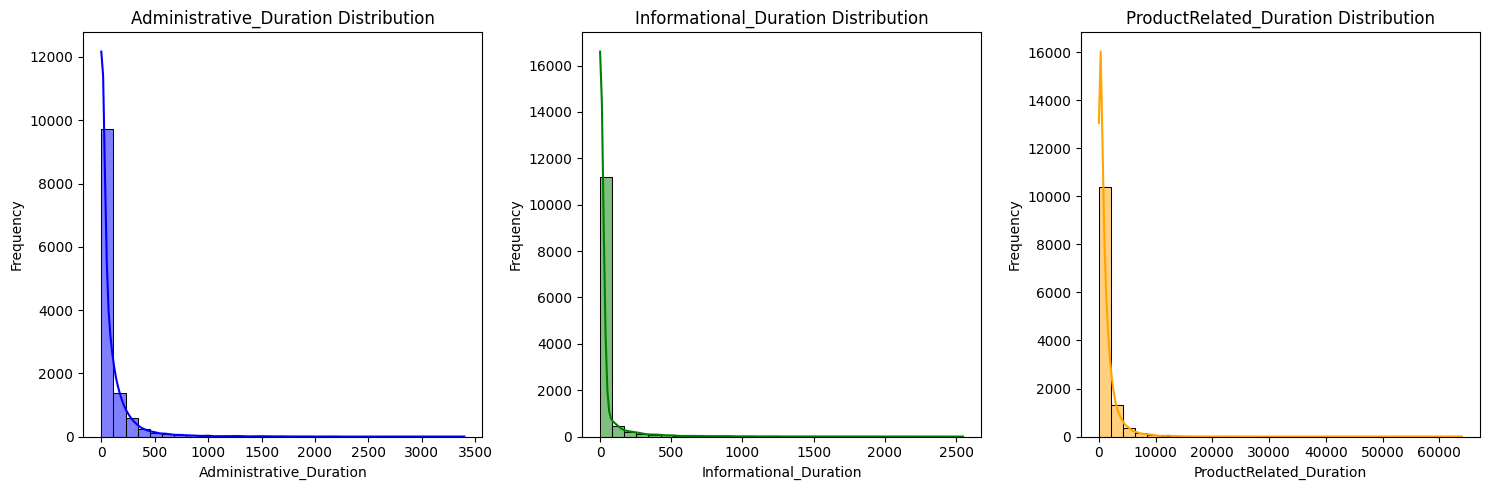

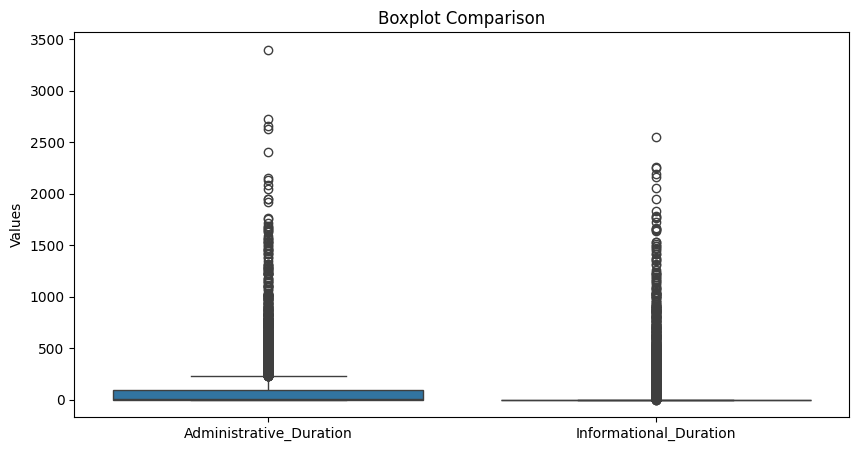

In [32]:
# Compare distributions of Administrative_Duration, Informational_Duration, and ProductRelated_Duration
plt.figure(figsize=(15, 5))

# Histogram for Administrative_Duration
plt.subplot(1, 3, 1)
sns.histplot(shopping_df['Administrative_Duration'], kde=True, bins=30, color='blue')
plt.title('Administrative_Duration Distribution')
plt.xlabel('Administrative_Duration')
plt.ylabel('Frequency')

# Histogram for Informational_Duration
plt.subplot(1, 3, 2)
sns.histplot(shopping_df['Informational_Duration'], kde=True, bins=30, color='green')
plt.title('Informational_Duration Distribution')
plt.xlabel('Informational_Duration')
plt.ylabel('Frequency')

# Histogram for ProductRelated_Duration
plt.subplot(1, 3, 3)
sns.histplot(shopping_df['ProductRelated_Duration'], kde=True, bins=30, color='orange')
plt.title('ProductRelated_Duration Distribution')
plt.xlabel('ProductRelated_Duration')
plt.ylabel('Frequency')

plt.tight_layout()

# Save the plot to figures/durations_histogram
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/durations_histogram.png", dpi=150)
plt.show()

# Boxplots for comparison
plt.figure(figsize=(10, 5))
sns.boxplot(data=shopping_df[['Administrative_Duration', 'Informational_Duration']])
plt.title('Boxplot Comparison')
plt.ylabel('Values')
plt.show()



## Conclusions:
duration_distributions_output ="figures/durations_histogram.png"
duration_distributions_comment = """
The three continous attributes describing the time duration spent share the same units (seconds) and expected behavior. The histogram graphs show significantly skewed data with a few outlier values having extremely high values. 
These outlier values will be further explored. The range of the three attributes differ, e.g. max value for informational pages is 2549.375 compared to the product related pages of 63973.52223, but their distribution is similar. This scenario seems plausible, 
as a user probably spends more time on product related pages.
"""

In [33]:
# Exploring the outlier records

print("Administrative_Duration")
display(shopping_df['Administrative_Duration'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["Administrative_Duration"] > 3000)])

print("Informational_Duration")
display(shopping_df['Informational_Duration'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["Informational_Duration"] > 2200)])

print("ProductRelated_Duration")
display(shopping_df['ProductRelated_Duration'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["ProductRelated_Duration"] > 30000)])




## Conclusions:
duration_outliers_output = display(shopping_df[(shopping_df["Administrative_Duration"] > 3000) | (shopping_df["Informational_Duration"] > 2300) | (shopping_df["ProductRelated_Duration"] > 40000)])
duration_outliers_comment = """
To assess the extremely high outlier values in the three duration attributes, the 90, 95, 99, 99.9% quantiles were checked and compared. For all the three attributes only the 99.9% quantiles showed
significant difference, therefore these records are checked manually, which filtered two records having high values for all three attributes. These outlier record show a different user behaviour 
from the rest of the observed sessions, however, it shows plausible, valid data features.
"""


Administrative_Duration


0.900     224.887500
0.950     348.266369
0.990     830.587041
0.999    1759.738667
Name: Administrative_Duration, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
8071,5,3398.75,6,2549.375,449,63973.52223,0.000764,0.027701,0.0,0.0,12,2,2,1,2,1,False,False


Informational_Duration


0.900      72.000000
0.950     195.000000
0.990     716.390000
0.999    1662.511434
Name: Informational_Duration, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
6020,8,116.972222,9,2252.033333,19,1135.880556,0.009677,0.011842,0.0,0.0,7,3,2,4,2,1,True,False
8071,5,3398.750000,6,2549.375000,449,63973.522230,0.000764,0.027701,0.0,0.0,12,2,2,1,2,1,False,False
10302,4,367.000000,5,2256.916667,74,8981.580128,0.002989,0.043302,0.0,0.0,12,2,2,1,8,1,False,False


ProductRelated_Duration


0.900     2877.863333
0.950     4300.289077
0.990     8701.142697
0.999    17397.813506
Name: ProductRelated_Duration, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5152,17,2629.253968,24,2050.433333,705,43171.23338,0.004851,0.015431,0.763829,0.0,5,2,2,1,14,1,True,False
8071,5,3398.750000,6,2549.375000,449,63973.52223,0.000764,0.027701,0.000000,0.0,12,2,2,1,2,1,False,False


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5152,17,2629.253968,24,2050.433333,705,43171.23338,0.004851,0.015431,0.763829,0.0,5,2,2,1,14,1,True,False
8071,5,3398.750000,6,2549.375000,449,63973.52223,0.000764,0.027701,0.000000,0.0,12,2,2,1,2,1,False,False


In [34]:
shopping_df[(shopping_df["Administrative_Duration"] > 3000) | (shopping_df["Informational_Duration"] > 2300) | (shopping_df["ProductRelated_Duration"] > 40000)]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5152,17,2629.253968,24,2050.433333,705,43171.23338,0.004851,0.015431,0.763829,0.0,5,2,2,1,14,1,True,False
8071,5,3398.750000,6,2549.375000,449,63973.52223,0.000764,0.027701,0.000000,0.0,12,2,2,1,2,1,False,False


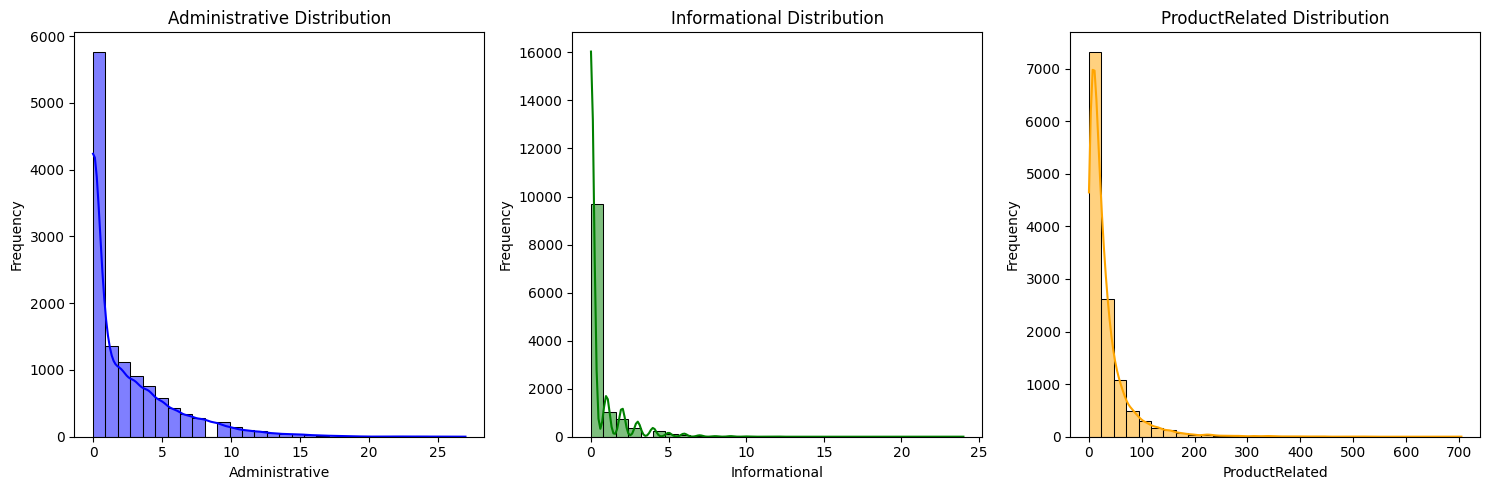

<Figure size 640x480 with 0 Axes>

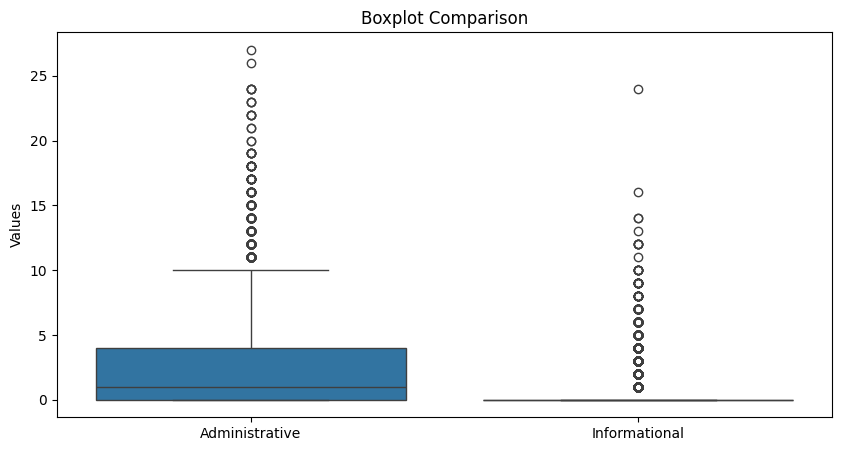

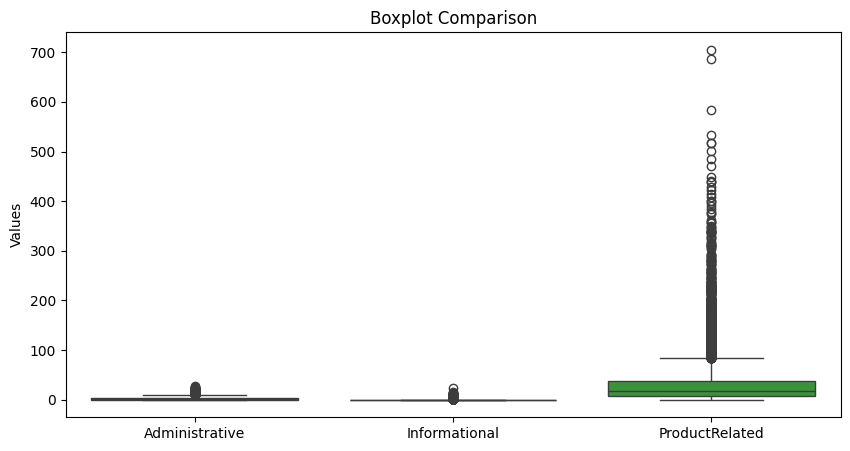

In [35]:
# Compare distributions of Administrative, Informational, and ProductRelated pagevisit columns
plt.figure(figsize=(15, 5))

# Histogram for Administrative
plt.subplot(1, 3, 1)
sns.histplot(shopping_df['Administrative'], kde=True, bins=30, color='blue')
plt.title('Administrative Distribution')
plt.xlabel('Administrative')
plt.ylabel('Frequency')

# Histogram for Informational
plt.subplot(1, 3, 2)
sns.histplot(shopping_df['Informational'], kde=True, bins=30, color='green')
plt.title('Informational Distribution')
plt.xlabel('Informational')
plt.ylabel('Frequency')

# Histogram for ProductRelated
plt.subplot(1, 3, 3)
sns.histplot(shopping_df['ProductRelated'], kde=True, bins=30, color='orange')
plt.title('ProductRelated Distribution')
plt.xlabel('ProductRelated')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Save the plot to figures/pagevisits_histogram
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/pagevisits_histogram.png", dpi=150)
plt.show()

# Boxplots for comparison
plt.figure(figsize=(10, 5))
sns.boxplot(data=shopping_df[['Administrative', 'Informational']])
plt.title('Boxplot Comparison')
plt.ylabel('Values')
plt.show()

# Boxplots for comparison
plt.figure(figsize=(10, 5))
sns.boxplot(data=shopping_df[['Administrative', 'Informational', 'ProductRelated']])
plt.title('Boxplot Comparison')
plt.ylabel('Values')
plt.show()


## Conclusions:
pagevisits_distributions_output ="figures/pagevisits_histogram.png"
pagevisits_distributions_comment = """
The three numerical attributes expressing the number of page visits in the sessions are closely related to the time durations, as it was shown in the correlation matrix. 
The histograms show similar distributions with right skewed outliers, but in a smaller range.
"""


In [36]:
# Exploring the outlier records

print("Administrative")
display(shopping_df['Administrative'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["Administrative"] > 21)])

print("Informational")
display(shopping_df['Informational'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["Informational"] > 10)])

print("ProductRelated")
display(shopping_df['ProductRelated'].quantile([0.90, 0.95, 0.99, 0.999]))
display(shopping_df[(shopping_df["ProductRelated"] > 500)])



## Conclusions:
pagevisits_outliers_output = display(display(shopping_df[(shopping_df["Administrative"] > 24) | (shopping_df["Informational"] > 15) | (shopping_df["ProductRelated"] > 550)]))
pagevisits_outliers_comment = """
After checking the values outside the 99.9% quantiles range, these record seem plausible, without any other correlation or pattern with other attributes. The two records previously filtered
for high duration times also show for the number of pages visited.
"""

Administrative


0.900     7.000
0.950     9.000
0.990    14.000
0.999    21.671
Name: Administrative, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1509,24,876.233333,5,625.500000,34,1588.666667,0.000000,0.013801,0.000000,0.0,3,2,2,5,2,1,False,False
2599,24,196.138592,1,28.000000,113,8699.407065,0.019308,0.047477,2.613453,0.0,5,2,2,6,11,1,True,False
4509,22,1951.279141,1,99.000000,55,3373.015865,0.016438,0.038293,8.508238,0.0,5,2,2,3,1,1,False,False
4937,24,290.860369,6,529.700000,178,4339.534423,0.003939,0.015263,6.149344,0.4,5,2,2,3,4,1,False,False
5597,24,468.100663,6,191.866667,189,3428.527381,0.018642,0.043831,0.870148,0.0,6,2,2,2,1,1,False,False
7504,23,335.130952,5,399.800000,88,1839.098106,0.015759,0.031588,0.000000,0.0,8,3,2,3,2,1,True,False
7828,23,239.744534,3,624.600000,409,9100.402959,0.004301,0.015935,6.277684,0.0,7,2,2,1,13,1,True,False
8308,27,853.735949,2,126.500000,584,24844.156200,0.002099,0.009347,4.511100,0.0,11,2,4,3,8,1,False,False
8349,22,438.330952,3,703.500000,178,6241.687398,0.002879,0.016886,2.038399,0.0,11,2,2,1,10,1,False,True
9078,23,322.941667,0,0.000000,62,3142.941176,0.003038,0.019685,7.311892,0.0,11,2,2,1,10,1,True,False


Informational


0.900     2.0
0.950     3.0
0.990     6.0
0.999    10.0
Name: Informational, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
184,0,0.000000,16,1210.397619,5,279.857143,0.003175,0.012764,0.000000,0.0,3,2,2,1,8,1,False,False
373,1,3.000000,14,1165.166667,81,2820.952419,0.008897,0.029431,0.000000,0.0,3,2,2,3,2,1,False,False
610,6,176.250000,12,404.000000,41,2720.671429,0.012963,0.033262,8.833826,0.0,3,2,2,2,2,1,True,True
4226,8,31.100000,11,1258.833333,195,7675.149290,0.001938,0.014674,3.382877,0.4,5,2,2,1,4,1,False,False
4316,15,370.275000,12,689.833333,96,2964.590278,0.002609,0.010732,3.358133,0.0,5,1,1,3,1,1,False,True
4378,14,1261.916667,12,985.419048,30,1956.022222,0.003084,0.022907,0.000000,0.6,5,2,2,3,2,1,False,False
5152,17,2629.253968,24,2050.433333,705,43171.233380,0.004851,0.015431,0.763829,0.0,5,2,2,1,14,1,True,False
6757,12,430.157017,14,622.400000,85,3684.855282,0.000935,0.009960,34.459435,0.0,11,3,2,1,2,1,True,False
8872,4,95.750000,12,886.250000,154,7838.556598,0.003765,0.014926,0.000000,0.0,11,3,2,6,2,1,True,False
9238,15,2657.318056,13,1949.166667,343,29970.465970,0.005316,0.028971,0.000000,0.0,12,2,2,1,2,1,False,False


ProductRelated


0.900     74.00
0.950    109.00
0.990    221.00
0.999    435.71
Name: ProductRelated, dtype: float64

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5152,17,2629.253968,24,2050.433333,705,43171.23338,0.004851,0.015431,0.763829,0.0,5,2,2,1,14,1,True,False
6684,20,199.456273,7,299.033333,686,23342.08205,0.009853,0.022771,0.150650,0.0,8,2,2,1,1,1,False,False
6787,8,161.668571,0,0.000000,518,11976.72135,0.000038,0.003837,0.000000,0.0,10,4,2,9,2,1,False,False
8308,27,853.735949,2,126.500000,584,24844.15620,0.002099,0.009347,4.511100,0.0,11,2,4,3,8,1,False,False
8784,20,1307.675000,3,132.666667,517,27009.85943,0.004385,0.014594,8.403164,0.0,11,1,1,1,2,1,False,True
8972,11,631.416667,5,1037.150000,501,21672.24425,0.003965,0.014292,9.131387,0.0,11,2,2,1,2,1,False,True
10318,9,444.284722,0,0.000000,534,18504.12621,0.010857,0.023309,2.547956,0.0,11,2,2,3,2,1,True,True


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
184,0,0.000000,16,1210.397619,5,279.857143,0.003175,0.012764,0.000000,0.0,3,2,2,1,8,1,False,False
5152,17,2629.253968,24,2050.433333,705,43171.233380,0.004851,0.015431,0.763829,0.0,5,2,2,1,14,1,True,False
6684,20,199.456273,7,299.033333,686,23342.082050,0.009853,0.022771,0.150650,0.0,8,2,2,1,1,1,False,False
8308,27,853.735949,2,126.500000,584,24844.156200,0.002099,0.009347,4.511100,0.0,11,2,4,3,8,1,False,False
12178,26,1561.717567,9,503.722222,183,9676.093180,0.011055,0.014200,19.567464,0.0,11,3,2,2,13,1,False,True


None

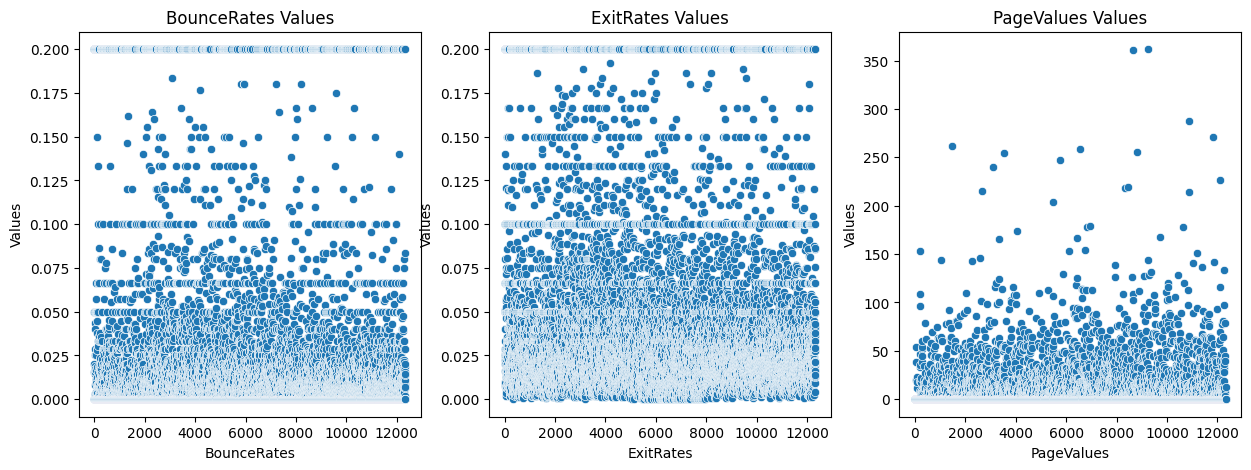

<Figure size 640x480 with 0 Axes>

In [37]:
# Compare distributions of BounceRates, ExitRates, PageValues columns
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(shopping_df["BounceRates"])
plt.title('BounceRates Values')
plt.xlabel('BounceRates')
plt.ylabel('Values')

plt.subplot(1, 3, 2)
sns.scatterplot(shopping_df["ExitRates"])
plt.title('ExitRates Values')
plt.xlabel('ExitRates')
plt.ylabel('Values')

plt.subplot(1, 3, 3)
sns.scatterplot(shopping_df["PageValues"])
plt.title('PageValues Values')
plt.xlabel('PageValues')
plt.ylabel('Values')    

# Save the plot to figures/continous_values
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/continous_values.png", dpi=150)
plt.show()

plt.tight_layout()
plt.show()




## Conclusions:
continous_distributions_output = "figures/continous_values.png"
continous_distributions_comment = """
Three attributes obtained from Google Analytics site have continous metrics values, and similar expected behavoiur, therefore they are examined together.
To check any outliers, semantically errorous values, we visualized the values on scatterplots. The BounceRates and ExitRates has an upper limit of 0.2, and has an even distribution of below this threshold.
The threshold was not mentioned in the official description, as these attributes express percentage units. However, these values should not be scaled, because their semantical meaning will be lost.
In the PageValues scatterplot, 2 records are visually distinguished with values higher than 350, which we marked as outliers to futher investigate. After looking at the 2 records, we didn't see any
other patterns, both of the sessions ended in Revenue.
"""

In [38]:
# The outlier values for PageValues
shopping_df[shopping_df["PageValues"] > 350]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
8635,0,0.0,0,0.0,44,784.883333,0.0,0.004762,360.953384,0.0,12,8,13,9,20,3,False,True
9239,3,37.5,0,0.0,18,607.500000,0.0,0.010526,361.763742,0.0,11,2,2,3,2,2,False,True


In [39]:
# Categorical attributes value counts, and relative proportions

display(pd.concat(
    [shopping_df["OperatingSystems"].value_counts(normalize=False), 
     shopping_df["OperatingSystems"].value_counts(normalize=True)*100],
    axis=1,
    keys=["Count", "Proportion in percentage"]))

display(pd.concat(
    [shopping_df["Browser"].value_counts(normalize=False), 
     shopping_df["Browser"].value_counts(normalize=True)*100],
    axis=1,
    keys=["Count", "Proportion in percentage"]))


display(shopping_df["Region"].value_counts())

display(pd.concat(
    [shopping_df["TrafficType"].value_counts(normalize=False), 
     shopping_df["TrafficType"].value_counts(normalize=True)*100],
    axis=1,
    keys=["Count", "Proportion in percentage"]))

display(pd.concat(
    [shopping_df["VisitorType"].value_counts(normalize=False), 
     shopping_df["VisitorType"].value_counts(normalize=True)*100],
    axis=1,
    keys=["Count", "Proportion in percentage"]))

,Count,Proportion in percentage
OperatingSystems,,
2,6601,53.536091
1,2585,20.965126
3,2555,20.721817
4,478,3.876723
8,79,0.640714
6,19,0.154096
7,7,0.056772
5,6,0.048662


,Count,Proportion in percentage
Browser,,
2,7961,64.566099
1,2462,19.967559
4,736,5.969181
5,467,3.787510
6,174,1.411192
10,163,1.321979
8,135,1.094891
3,105,0.851582
13,61,0.494728


Region
1    4780
3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: count, dtype: int64

,Count,Proportion in percentage
TrafficType,,
2,3913,31.735604
1,2451,19.878345
3,2052,16.642336
4,1069,8.669911
13,738,5.985401
10,450,3.649635
6,444,3.600973
8,343,2.781833
5,260,2.108678


,Count,Proportion in percentage
VisitorType,,
1,10551,85.571776
2,1694,13.738848
3,85,0.689376


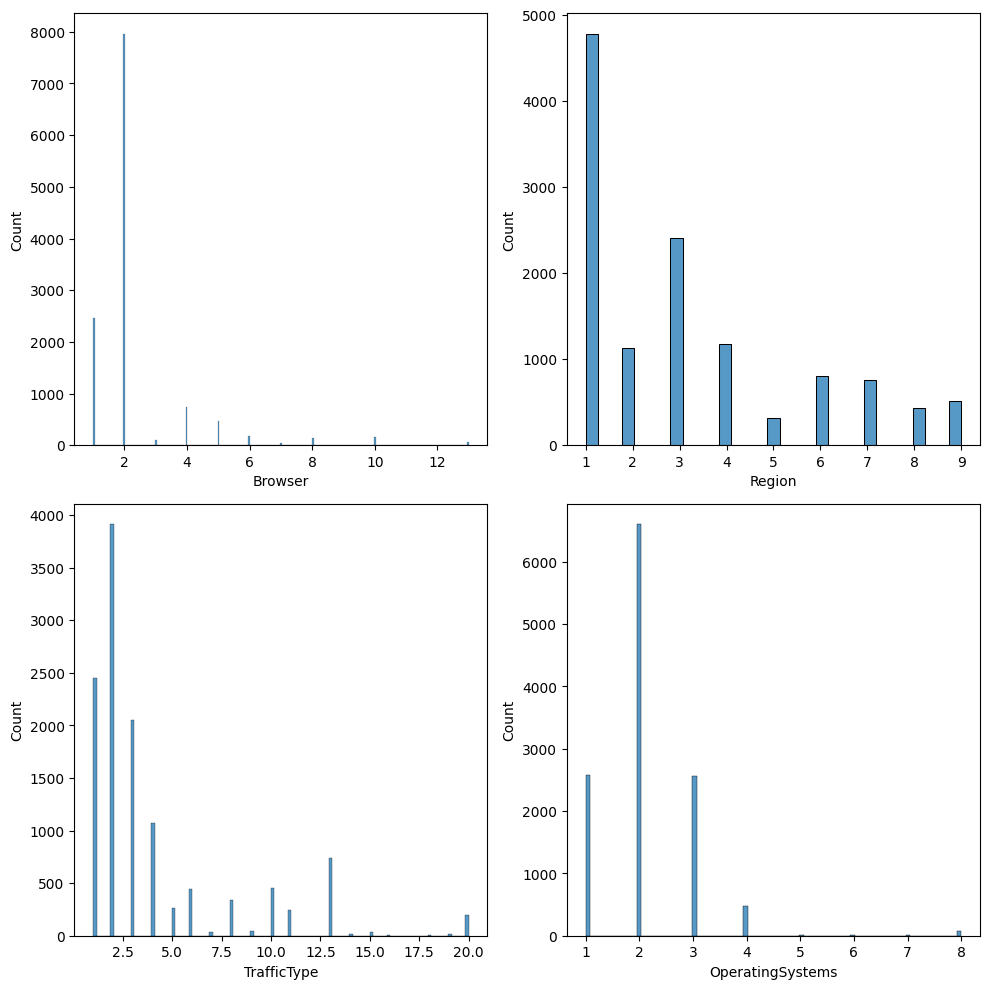

In [40]:
# Distributions of categorical attributes
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(shopping_df["Browser"])

plt.subplot(2, 2, 2)
sns.histplot(shopping_df["Region"])

plt.subplot(2, 2, 3)
sns.histplot(shopping_df["TrafficType"])

plt.subplot(2, 2, 4)
sns.histplot(shopping_df["OperatingSystems"])

# Save the plot to figures/categorical_distributions
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/categorical_distributions.png", dpi=150)
plt.tight_layout()
plt.show()



## Conclusions:
categorical_distributions_output = "figures/categorical_distributions.png"
categorical_distributions_comment = """
For the categorical attributes of Browser, Region, TrafficType, OperatingSystems and Visitor Type we explored the value counts in each categories, and plotted the histograms. We didn't expect even
distribution between the classes, as it would not be a realistic scenario, however, the under represented classes had to be checked to decide if the data is representative. For example in some browser types there 
were only a few records in the dataset, which might be a sign that our designed model will not be able to generalize over that given browser type. In our opinion 3 categories of Browser types, 4 categories of Traffic Types
and 2 categories of Operating Systems are underrepresented having less than 0.1% of the data (~less than 5 records). 
We handle the Visitor Type attribute as a categorical feature. Even though the official provenance described the attribute as a two-class label, there are 85 "other" categories.
"""

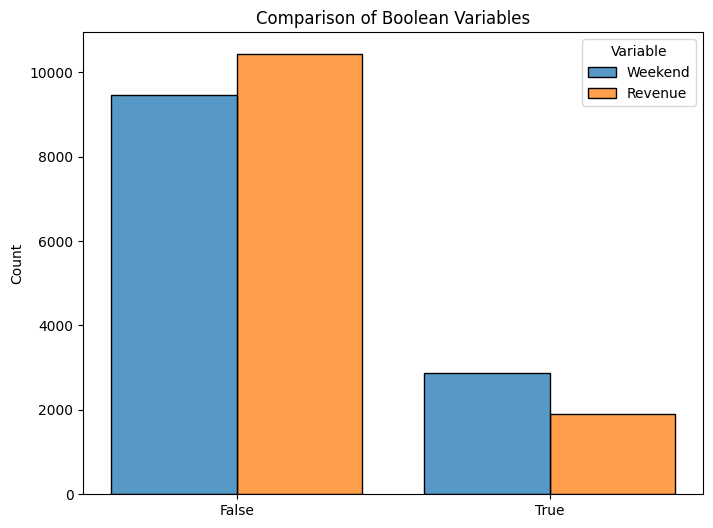

In [41]:
# Compare binary attributes: Weekend vs Revenue distributions 
plt.figure(figsize=(8, 6))
bool_long = shopping_df[['Weekend', 'Revenue']].melt(
    var_name='Variable', value_name='Boolean_Value'
)
bool_long['Boolean_Value'] = bool_long['Boolean_Value'].astype(int)

ax = sns.histplot(
    data=bool_long,
    x='Boolean_Value',
    hue='Variable',
    multiple='dodge',
    shrink=0.8,
    discrete=True
)

# Refine the axis labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['False', 'True'])
ax.set_xlabel('')
ax.set_title('Comparison of Boolean Variables')


# Save the plot to figures/binary_distribution
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/binary_distribution.png", dpi=150)
plt.show()



## Conclusions:
binary_distributions_output = "figures/binary_distribution.png"
binary_distributions_comment = """
Both Weekend and Revenue are binary attributes. The Revenue attribute is highly imbalanced, with many more False than True values.
The Weekend attribute is close to its natural distribution, as 2/7 = 28.57% of a calendar year is weekend.
"""

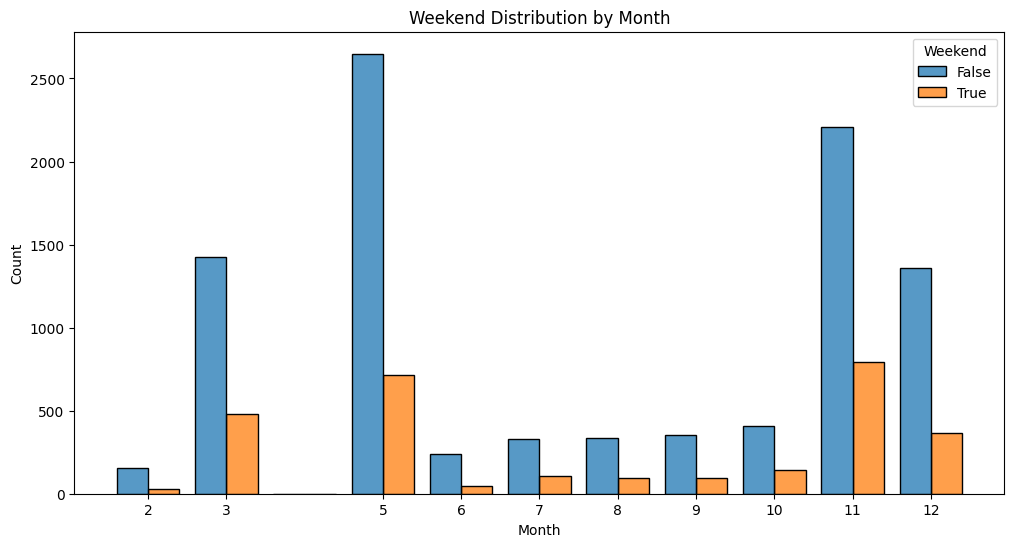

In [42]:
# Group by Month and calculate proportions of Weekend (True vs False)
display(weekend_distribution_output = shopping_df.groupby('Month')['Weekend'].value_counts(normalize=True).unstack())

plt.figure(figsize=(12, 6))
sns.histplot(
    data=shopping_df,
    x='Month',
    hue='Weekend',
    multiple='dodge',
    shrink=0.8,
    discrete=True
)
plt.title('Weekend Distribution by Month')
plt.xlabel('Month')
plt.xticks(ticks=shopping_df['Month'].unique(), labels=shopping_df['Month'].unique())

# Save the plot
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/weekend_distribution.png", dpi=150)
plt.show()


## Conclusions:
weekend_distributions_output = "figures/weekend_distribution.png"
weekend_distributions_comment = """
Although the weekend attribute is imbalanced, its distribution is relatively consistent across months, ranging from approximately 15% to 25% weekend each month.
"""


In [43]:
def check_zscore_outliers(df: pd.DataFrame, threshold=3.0, columns: list = None) -> dict:
    results = {}

    for col in columns:
        values = df[col].astype(float)

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std

        mask = np.abs(z_scores) > threshold
        outliers = values[mask].index

        outlier_info = [
            {
                'index': int(idx),
                'z_score': float(z_scores.loc[idx])
            }
            for idx in outliers
        ]

        results[col] = outlier_info

    return results


In [44]:
data_understanding_2c_code_writer = student_a

def data_understanding_2c():
    check_zscore_outliers(shopping_df, threshold=10.0, columns = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues"])


start_time_data_understanding_2c = now()
outliers_report = data_understanding_2c()
end_time_data_understanding_2c = now()


############################################################
# 2c Documentation (Provenance)
############################################################

data_understanding_2c_ass_uuid_executor = "153ad75c-19b9-4862-abd7-7470e84cd5c3" #generated, do not modify
data_understanding_2c_ass_uuid_writer   = "198161c2-7428-4445-9c76-092123e9659a" #generated, do not modify

data_understanding_2c_comment = """
Data Understanding 2c: To explore the statistical nature of the dataset, we check the data quality including missing values, 
outliers, distributions and imbalance of numerical and categorical attributes.
This step performs systematic data quality checks to support later preprocessing decisions.
"""

data_understanding_2c_activity = [

    # Activity Definition
    ':data_understanding_2c rdf:type prov:Activity .',
    ':data_understanding_2c sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2c rdfs:label "2c Data Quality Analysis" .',
    f':data_understanding_2c rdfs:comment """{data_understanding_2c_comment}""" .',

    # Timing
    f':data_understanding_2c prov:startedAtTime "{start_time_data_understanding_2c}"^^xsd:dateTime .',
    f':data_understanding_2c prov:endedAtTime "{end_time_data_understanding_2c}"^^xsd:dateTime .',

    # Associations: executor
    f':data_understanding_2c prov:qualifiedAssociation :{data_understanding_2c_ass_uuid_executor} .',
    f':{data_understanding_2c_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2c_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2c_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Associations: writer
    f':data_understanding_2c prov:qualifiedAssociation :{data_understanding_2c_ass_uuid_writer} .',
    f':{data_understanding_2c_ass_uuid_writer} prov:agent :{data_understanding_2c_code_writer} .',
    f':{data_understanding_2c_ass_uuid_writer} rdf:type prov:Association .',
    f':{data_understanding_2c_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # === Entity: Duration Distributions ===
    f':data_understanding_2c_duration_distributions rdf:type prov:Entity .',
    f':data_understanding_2c_duration_distributions rdfs:label "Compare Distributions of Duration Attributes" .',
#    f':data_understanding_2c_duration_distributions rdfs:comment """Distribution of the duration attributes: {duration_distributions_output}\n\n{duration_distributions_comment}""" .',
    f':data_understanding_2c_duration_distributions prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Duration Outliers ===
    f':data_understanding_2c_duration_outliers rdf:type prov:Entity .',
    f':data_understanding_2c_duration_outliers rdfs:label "Duration Outliers" .',
#   f':data_understanding_2c_duration_outliers rdfs:comment """Duration outliers output: {duration_outliers_output}\n\n{duration_outliers_comment}""" .',
    f':data_understanding_2c_duration_outliers prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Pagevisit Distributions ===
    f':data_understanding_2c_pagevisit_distributions rdf:type prov:Entity .',
    f':data_understanding_2c_pagevisit_distributions rdfs:label "Compare Distributions of Pagevisit Attributes" .',
#    f':data_understanding_2c_pagevisit_distributions rdfs:comment """Distribution of the pagevisit attributes: {pagevisits_distributions_output}\n\n{pagevisits_distributions_comment}""" .',
    f':data_understanding_2c_pagevisit_distributions prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Pagevisit Outliers ===
    f':data_understanding_2c_pagevisit_outliers rdf:type prov:Entity .',
    f':data_understanding_2c_pagevisit_outliers rdfs:label "Pagevisit Outliers" .',
#    f':data_understanding_2c_pagevisit_outliers rdfs:comment """Pagevisit outliers output: {pagevisits_outliers_output}\n\n{pagevisits_outliers_comment}""" .',
    f':data_understanding_2c_pagevisit_outliers prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Distributions of Continuous Attributes ===
    f':data_understanding_2c_continuous_distributions rdf:type prov:Entity .',
    f':data_understanding_2c_continuous_distributions rdfs:label "Distributions of Continuous Attributes" .',
#    f':data_understanding_2c_continuous_distributions rdfs:comment """Continuous distributions output: {continous_distributions_output}\n\n{continous_distributions_comment}""" .',
    f':data_understanding_2c_continuous_distributions prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Distributions of Categorical Attributes ===
    f':data_understanding_2c_categorical_distributions rdf:type prov:Entity .',
    f':data_understanding_2c_categorical_distributions rdfs:label "Distributions of Categorical Attributes" .',
#    f':data_understanding_2c_categorical_distributions rdfs:comment """Categorical distributions output: {categorical_distributions_output}\n\n{categorical_distributions_comment}""" .',
    f':data_understanding_2c_categorical_distributions prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Binary Distributions ===
    f':data_understanding_2c_binary_values rdf:type prov:Entity .',
    f':data_understanding_2c_binary_values rdfs:label "Binary Values" .',
#    f':data_understanding_2c_binary_values rdfs:comment """Binary values output: {binary_distributions_output}\n\n{binary_distributions_comment}""" .',
    f':data_understanding_2c_binary_values prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Weekend Distribution ===
    f':data_understanding_2c_weekend_distribution rdf:type prov:Entity .',
    f':data_understanding_2c_weekend_distribution rdfs:label "Weekend Distribution" .',
#    f':data_understanding_2c_weekend_distribution rdfs:comment """Weekend distribution output: {weekend_distributions_output}\n\n{weekend_distributions_comment}""" .',
    f':data_understanding_2c_weekend_distribution prov:wasGeneratedBy :data_understanding_2c .',

    # === Entity: Z-score Outliers ===
    f':data_understanding_2c_zscore_outliers rdf:type prov:Entity .',
    f':data_understanding_2c_zscore_outliers rdfs:label "Z-score Outliers" .',
    f':data_understanding_2c_zscore_outliers rdfs:comment """Z-score outliers output: {outliers_report}\n\n{outliers_report}""" .',
    f':data_understanding_2c_zscore_outliers prov:wasGeneratedBy :data_understanding_2c .',

]

#engine.insert(data_understanding_2c_activity, prefixes=prefixes)


### 2.d Visual exploration of data properties and hypotheses

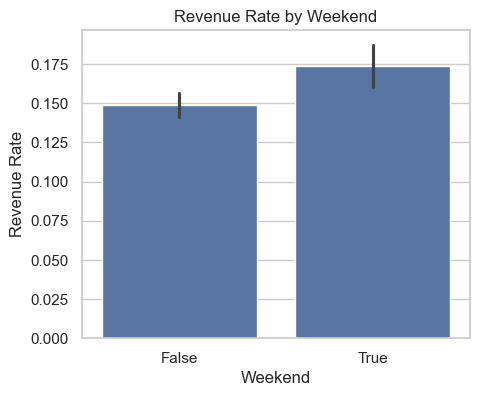

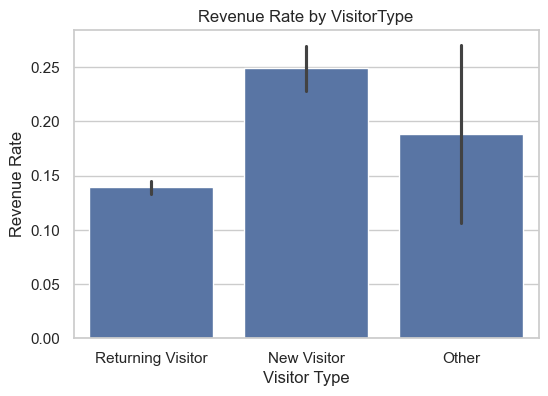

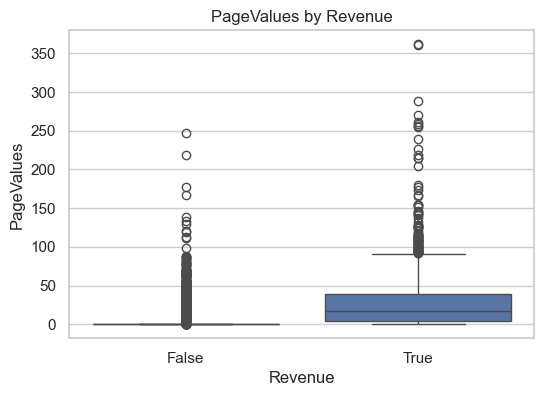

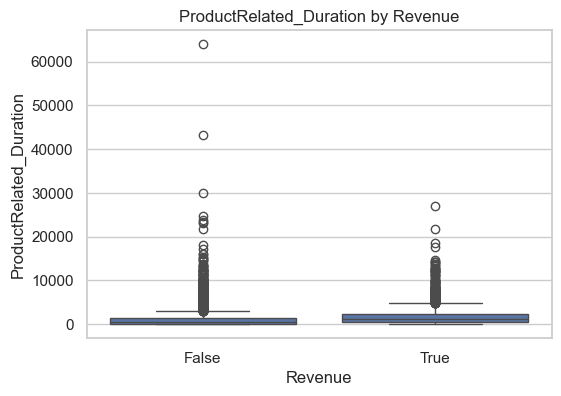

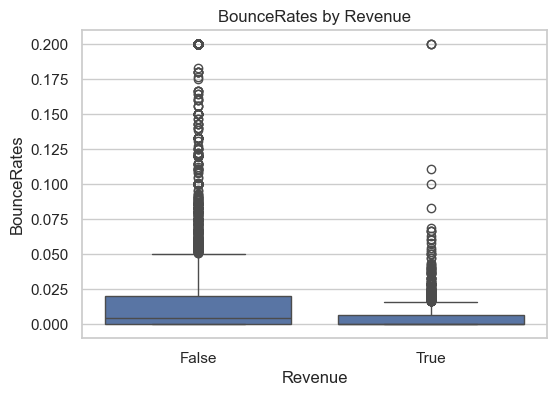

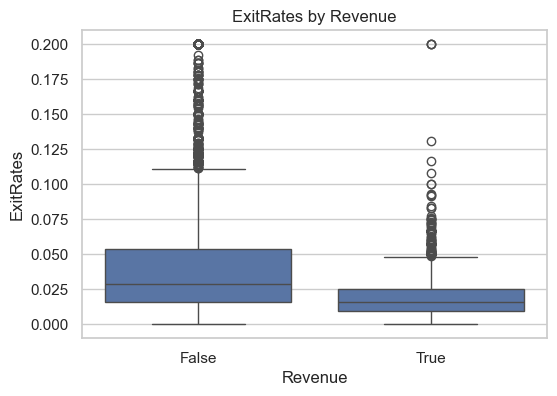

In [45]:
def data_understanding_2d():
        
    sns.set(style="whitegrid")

    # Ensure Revenue is int for plotting where needed
    df = shopping_df.copy()
    df["Revenue_int"] = df["Revenue"].astype(int)
    df["Weekend_int"] = df["Weekend"].astype(int)

    # 1) Revenue vs Weekend
    # Plotting revenue rate by weekend status to check whether the revenue is higher on weekends than weekdays.
    # Revenue is higher on weekends than weekdays: true. The number of sessions ended with revenue on weekends are higher than those on weekdays. However, this small difference can be handled as irrelevant.
    plt.figure(figsize=(5,4))
    sns.barplot(data=df, x="Weekend", y="Revenue_int")
    plt.title("Revenue Rate by Weekend")
    plt.ylabel("Revenue Rate")
    plt.show()

    # 2) Revenue vs VisitorType
    # Returning visitors have higher Revenue rate than new visitors: false. The New Visitors have slightly higher rate of Revenue.
    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x="VisitorType", y="Revenue_int")
    plt.title("Revenue Rate by VisitorType")
    plt.xlabel("Visitor Type")
    plt.xticks(ticks=[0, 1, 2], labels=["Returning Visitor", "New Visitor", "Other"])
    plt.ylabel("Revenue Rate")
    plt.show()

    # 3) PageValues in different Revenue results
    # Higher PageValues correlates with higher chance of Revenue: true. The graph shows clear difference of higher page values in the case of True Revenue.
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Revenue", y="PageValues")
    plt.title("PageValues by Revenue")
    plt.show() 

    # 4) ProductRelated_Duration vs Revenue
    # Longer ProductRelated_Duration is associated with higher rate of Revenue: true, but irrelevant. Although for the majority of data in the sessions with Revenue the duration is slightly longer, the extreme outlier values appear in the sessions without Revenue.
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Revenue", y="ProductRelated_Duration")
    plt.title("ProductRelated_Duration by Revenue")
    plt.show()

    # 5) BounceRates vs Revenue
    # High BounceRates correspond to low rate of Revenue: true. Bounce rates are clearly higher in the sessions without Revenue.
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Revenue", y="BounceRates")
    plt.title("BounceRates by Revenue")
    plt.show()

    # 6) ExitRates vs Revenue
    # ExitRates are higher for non‑purchasing sessions.: true. Both BounceRates and ExitRates are clearly higher in the sessions without Revenue, with an even greater difference as in Bounce rates.
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="Revenue", y="ExitRates")
    plt.title("ExitRates by Revenue")
    plt.show()

data_understanding_2d()

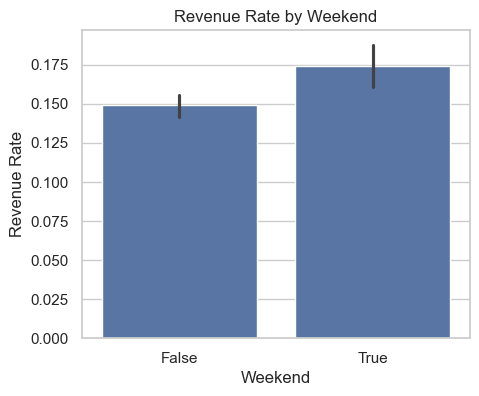

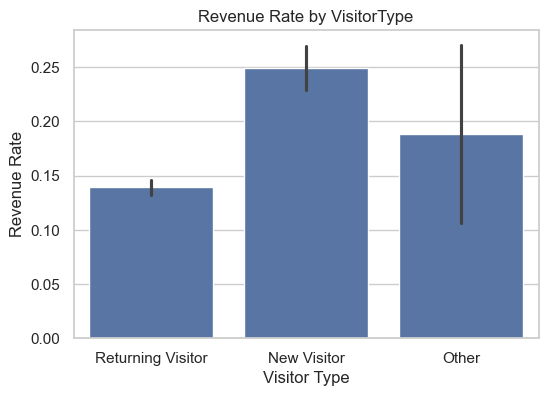

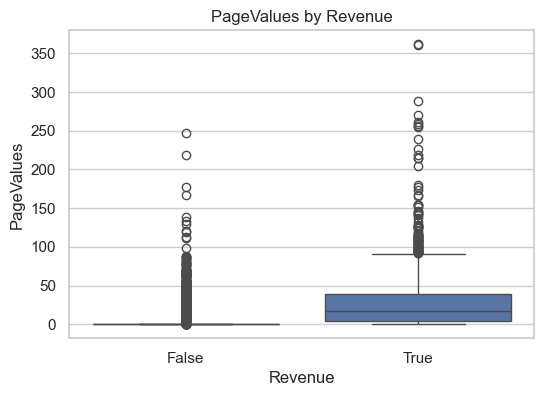

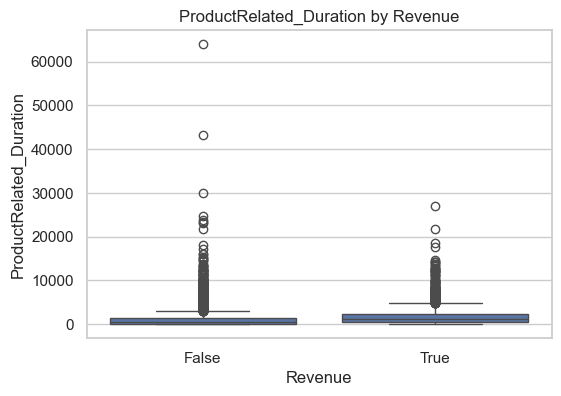

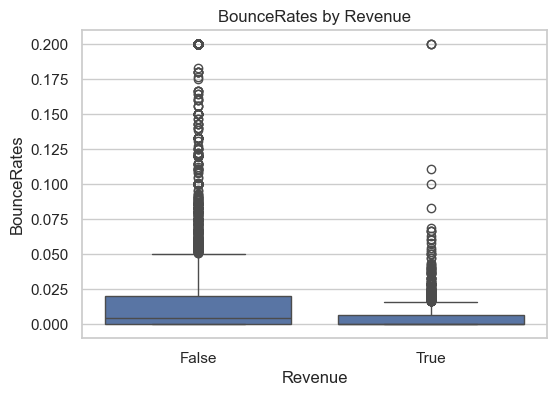

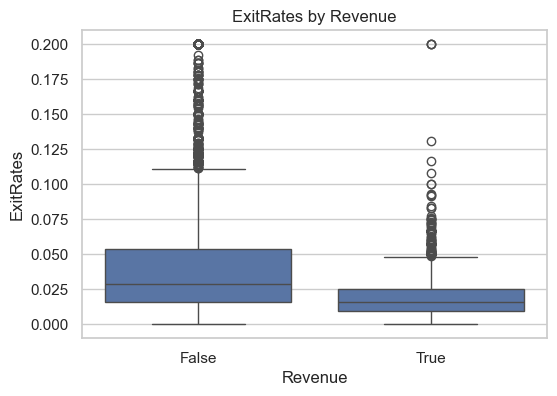

HTTPError: HTTP Error 403: Forbidden

In [46]:
data_understanding_2d_code_writer = student_a


start_time_data_understanding_2d = now()
res = data_understanding_2d()
end_time_data_understanding_2d = now()


############################################################
# 2d Documentation (Provenance)
############################################################

data_understanding_2d_ass_uuid_executor = "1013252c-95de-4abc-a3b9-3aa30c4332c8" #generated, do not modify
data_understanding_2d_ass_uuid_writer   = "e9d901eb-412d-4d03-9fbc-baf7a2cd6f7f" #generated, do not modify
data_understanding_2d_comment = """
Data Understanding 2d: 
Through visualizing the patterns in the data we explored the following hypothesis:
1) Revenue is higher on weekends than weekdays: true. The number of sessions ended with revenue on weekends are higher than those on weekdays. However, this small difference can be handled as irrelevant.
2) Returning visitors have higher Revenue rate than new visitors: false. The New Visitors have slightly higher rate of Revenue.
3) Higher PageValues correlates with higher Revenue: true. The graph shows clear difference of higher page values in the case of True Revenue.
4) Longer ProductRelated Duration is associated with higher rate of Revenue: true, but irrelevant. Although for the majority of data in the sessions with Revenue the duration is slightly longer, the extreme outlier values appear in the sessions without Revenue.  
5) High BounceRates correspond to low Revenue rate: true. BounceRates are clearly higher in the sessions without Revenue.
6) ExitRates are higher for non-purchasing sessions.: true. Both BounceRates and ExitRates are clearly higher in the sessions without Revenue, with an even greater difference as in Bounce rates.
"""


data_understanding_2d_activity = [

    # Activity Definition
    ':data_understanding_2d rdf:type prov:Activity .',
    ':data_understanding_2d sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2d rdfs:label "2d Data Quality Analysis" .',
    f':data_understanding_2d rdfs:comment """{data_understanding_2d_comment}""" .',

    # Timing
    f':data_understanding_2d prov:startedAtTime "{start_time_data_understanding_2d}"^^xsd:dateTime .',
    f':data_understanding_2d prov:endedAtTime "{end_time_data_understanding_2d}"^^xsd:dateTime .',

    # Associations: executor
    f':data_understanding_2d prov:qualifiedAssociation :{data_understanding_2d_ass_uuid_executor} .',
    f':{data_understanding_2d_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2d_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2d_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    # Associations: writer
    f':data_understanding_2d prov:qualifiedAssociation :{data_understanding_2d_ass_uuid_writer} .',
    f':{data_understanding_2d_ass_uuid_writer} prov:agent :{data_understanding_2d_code_writer} .',
    f':{data_understanding_2d_ass_uuid_writer} rdf:type prov:Association .',
    f':{data_understanding_2d_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
   
    # === Entity 1: Revenue vs Weekend ===
    ':data_understanding_2d_weekend_revenue_plot rdf:type prov:Entity .',
    ':data_understanding_2d_weekend_revenue_plot rdfs:label "Hypothesis 1: Revenue by Weekend" .',
    ':data_understanding_2d_weekend_revenue_plot rdfs:comment """Hypothesis: Revenue is higher on weekends than on weekdays. The bar plot of Revenue rate by Weekend shows a slightly higher Revenue rate on weekends compared to weekdays. However, the difference is small and is considered practically negligible for business decisions.""" .',
    ':data_understanding_2d_weekend_revenue_plot prov:wasGeneratedBy :data_understanding_2d .',

    # === Entity 2: Revenue vs VisitorType ===
    ':data_understanding_2d_visitor_revenue_plot rdf:type prov:Entity .',
    ':data_understanding_2d_visitor_revenue_plot rdfs:label "Hypothesis 2: Revenue by VisitorType" .',
    ':data_understanding_2d_visitor_revenue_plot rdfs:comment """Hypothesis: Returning visitors have a higher Revenue rate than new visitors. The bar plot of Revenue rate by VisitorType indicates that New Visitors actually have a slightly higher Revenue rate than Returning Visitors. The difference is small but contradicts the initial expectation that returning visitors would convert better.""" .',
    ':data_understanding_2d_visitor_revenue_plot prov:wasGeneratedBy :data_understanding_2d .',

    # === Entity 3: PageValues by Revenue ===
    ':data_understanding_2d_pagevalues_revenue_plot rdf:type prov:Entity .',
    ':data_understanding_2d_pagevalues_revenue_plot rdfs:label "Hypothesis 3: PageValues by Revenue" .',
    ':data_understanding_2d_pagevalues_revenue_plot rdfs:comment """Hypothesis: Higher PageValues correlate with a higher chance of Revenue. The boxplot of PageValues by Revenue shows clearly higher PageValues for sessions with Revenue=True compared to Revenue=False, confirming the hypothesis that PageValues is a strong indicator of purchasing behavior.""" .',
    ':data_understanding_2d_pagevalues_revenue_plot prov:wasGeneratedBy :data_understanding_2d .',

    # === Entity 4: ProductRelated_Duration vs Revenue ===
    ':data_understanding_2d_product_duration_revenue_plot rdf:type prov:Entity .',
    ':data_understanding_2d_product_duration_revenue_plot rdfs:label "Hypothesis 4: ProductRelated_Duration by Revenue" .',
    ':data_understanding_2d_product_duration_revenue_plot rdfs:comment """Hypothesis: Longer ProductRelated_Duration is associated with a higher Revenue rate. The boxplot of ProductRelated_Duration by Revenue shows slightly longer median durations for sessions with Revenue=True, but extreme outlier values occur mostly in sessions without Revenue. The effect is present but modest and potentially less actionable due to noisy outliers.""" .',
    ':data_understanding_2d_product_duration_revenue_plot prov:wasGeneratedBy :data_understanding_2d .',

    # === Entity 5: BounceRates vs Revenue ===
    ':data_understanding_2d_bouncerates_revenue_plot rdf:type prov:Entity .',
    ':data_understanding_2d_bouncerates_revenue_plot rdfs:label "Hypothesis 5: BounceRates by Revenue" .',
    ':data_understanding_2d_bouncerates_revenue_plot rdfs:comment """Hypothesis: High BounceRates correspond to low Revenue rates. The boxplot of BounceRates by Revenue shows clearly higher BounceRates in sessions without Revenue compared to sessions with Revenue. This confirms that high bounce behavior is strongly associated with non-purchasing sessions.""" .',
    ':data_understanding_2d_bouncerates_revenue_plot prov:wasGeneratedBy :data_understanding_2d .',

    # === Entity 6: ExitRates vs Revenue ===
    ':data_understanding_2d_exitrates_revenue_plot rdf:type prov:Entity .',
    ':data_understanding_2d_exitrates_revenue_plot rdfs:label "Hypothesis 6: ExitRates by Revenue" .',
    ':data_understanding_2d_exitrates_revenue_plot rdfs:comment """Hypothesis: ExitRates are higher for non-purchasing sessions. The boxplot of ExitRates by Revenue shows substantially higher ExitRates for sessions with Revenue=False than for Revenue=True. The difference is even larger than for BounceRates, reinforcing the conclusion that frequent exits correlate with non-purchasing behavior.""" .',
    ':data_understanding_2d_exitrates_revenue_plot prov:wasGeneratedBy :data_understanding_2d .',

]

engine.insert(data_understanding_2d_activity, prefixes=prefixes)

### 2.e Sensitive data
Evaluate and document whether the data set contains attributes that are potentially ethically sensitive, minority classes or underrepresented data groups, unbalanced distributions with respect to bias (to guide over- and under-sampling, micro- and macro evaluation criteria)

In [47]:
data_understanding_2e_ass_uuid_executor = "ab8b679b-9d9a-4220-aa40-27b35ac6d953" #generated, do not modify


data_understanding_2e_comment = """
The dataset does not contain direct personally identifiable information (PII); however, attributes 
such as 'Region', 'OperatingSystems', and 'Browser' act as technical and geographic identifiers that 
could indirectly represent specific user demographics.

Statistical analysis reveals significant unbalanced distributions across several key fields:
1. Target Imbalance: The target variable 'Revenue' is highly skewed, with only 15.5% of sessions 
   resulting in a purchase, compared to 84.5% non-purchase sessions.
2. Minority Classes: 'VisitorType' is dominated by 'Returning_Visitor' (85.6%), leaving 'New_Visitor' 
   (13.7%) and 'Other' (0.69%) as underrepresented groups.
3. Technical Skew: 'OperatingSystem 2' (53.5%) and 'Browser 2' (64.5%) represent the vast majority 
   of the data, while several other categories in these fields (and 'TrafficType') account for less 
   than 1% of the total records.

These imbalances indicate that a standard classification model may become biased toward the majority 
classes (e.g., non-purchasing returning visitors on OS 2). To mitigate this, data preparation should 
include over-sampling or under-sampling techniques. Furthermore, model evaluation should utilize 
macro-averaged criteria and F1-scores rather than accuracy to ensures performance is accurately 
measured for the minority purchasing class.
"""


data_understanding_2e_activity = [
    # Activity definition
    ':data_understanding_2e rdf:type prov:Activity .',
    ':data_understanding_2e sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2e rdfs:label "2e Sensitive data" .',
    f':data_understanding_2e rdfs:comment """{data_understanding_2e_comment}""" .',


    # Associations: executor
    f':data_understanding_2e prov:qualifiedAssociation :{data_understanding_2e_ass_uuid_executor} .',
    f':{data_understanding_2e_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2e_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2e_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

]

engine.insert(data_understanding_2e_activity, prefixes=prefixes)

### 2.f Potential risk and bias
What potential risks and additional types of bias exist in the data? What questions would you need to have answered by an external expert in order to determine potential bias or data quality issues?


In [48]:
data_understanding_2f_ass_uuid_executor = "fb246012-e80d-4335-8d7e-5992f4ef9ac3" #generated, do not modify


data_understanding_2f_comment = """
1. Data Quality Observations:
   - VisitorType: The 'Other' category accounts for less than 1% of the dataset (0.69%). 
     As it is not formally defined in the data documentation, its semantic meaning 
     is unclear and may require consultation with an external domain expert. Given 
     its low frequency, it is unlikely to be a primary driver for the model.
   - Month: The months of January and April are missing from the dataset. While the 
     overall distribution of the remaining months appears normal, the absence of 
     these specific periods should be verified with an expert to ensure there is 
     no systematic sampling bias or technical data loss.

2. Outlier Evaluation:
   - High Kurtosis is observed in 'ProductRelated_Duration' (137.17), 'PageValues' (65.64), 
     and 'Administrative_Duration' (50.56) and represent valid, high-value user sessions 
     (e.g., indices 8635 and 9239 in PageValues).
"""


data_understanding_2f_activity = [
    # Activity definition
    ':data_understanding_2f rdf:type prov:Activity .',
    ':data_understanding_2f sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2f rdfs:label "2f Potential risk and bias" .',
    f':data_understanding_2f rdfs:comment """{data_understanding_2f_comment}""" .',


    # Associations: executor
    f':data_understanding_2f prov:qualifiedAssociation :{data_understanding_2f_ass_uuid_executor} .',
    f':{data_understanding_2f_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2f_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2f_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

]

engine.insert(data_understanding_2f_activity, prefixes=prefixes)

### 2.g Which actions are likely required in data preparation based on this analysis?

In [ ]:
str(uuid.uuid4())

In [49]:
data_understanding_2g_ass_uuid_executor = "1e1da868-fe9a-45d5-b693-f3d27a7e656e" #generated, do not modify


data_understanding_2g_comment = """
As a summary of data quality and planned treatment strategy we would like to mention
the following aspects:

1. Missing Values: The dataset is complete with zero missing values. This ensures that 
   the integrity of the feature set is maintained without the need for synthetic 
   imputation or data removal.

2. Correlation Analysis: While high correlations exist between metrics like BounceRates 
   and ExitRates, we have decided not to remove any attributes. These features capture 
   different nuances of user behavior (initial bounce vs. eventual exit), and retaining 
   both allows non-parametric models to utilize these interaction signals for better 
   prediction of Revenue.

3. Outlier Management (Numerical):
   Numerical attributes (page counts and durations) are highly right-skewed. However, 
   most 'extreme' outliers (those beyond the 99th percentile) frequently coincide 
   with high PageValues and Revenue = True, indicating they don't represent errors. 
   To address the issue we are going to standardize these attributes with Z-score 
   scaling because it preserves the relative relationships of the outliers while 
   bringing all features onto a common scale (mean=0, std=1).

4. Outlier Management (Categorical):
   Features such as OperatingSystems, Browser, and TrafficType contain categories 
   with frequencies below 1%, which in our opinion would rarely provide enough 
   statistical power for a model to learn meaningful patterns. Instead of removing 
   these records, we will use binning, so all categories falling below the 1% threshold 
   will be grouped into a single 'Other' category. This reduces the dimensionality of 
   the data while retaining the total sample size and acknowledging the presence of 
   minority technical configurations.

5. Target Variable (Revenue): The significant class imbalance (~15.5% purchase rate) 
   requires careful handling during the Modeling phase. We will prioritize 
   stratified train-test splitting and utilize evaluation metrics like the 
   Macro-F1 scoreto ensure the model effectively identifies the minority class.
"""


data_understanding_2g_activity = [
    # Activity definition
    ':data_understanding_2g rdf:type prov:Activity .',
    ':data_understanding_2g sc:isPartOf :data_understanding_phase .',
    ':data_understanding_2g rdfs:label "2g Likely actions" .',
    f':data_understanding_2g rdfs:comment """{data_understanding_2g_comment}""" .',


    # Associations: executor
    f':data_understanding_2g prov:qualifiedAssociation :{data_understanding_2g_ass_uuid_executor} .',
    f':{data_understanding_2g_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{data_understanding_2g_ass_uuid_executor} rdf:type prov:Association .',
    f':{data_understanding_2g_ass_uuid_executor} prov:hadRole :{code_executor_role} .',


]

engine.insert(data_understanding_2g_activity, prefixes=prefixes)


## Data Preparation

In [50]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
#engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [51]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    
    categorical_cols = ['OperatingSystems', 'Browser', 'TrafficType']
    
    for col in categorical_cols:
        
        relative_freq = df[col].value_counts(normalize=True)
        small_categories = relative_freq[relative_freq < 0.01].index
        df[col] = df[col].replace(small_categories, 0)

    return df

start_time_td = now()
handle_outliers(shopping_df, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "8b93a25b-2148-479c-a845-57fe34a88ff5" # generated, do not modify
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
# engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "99be711a-f27b-4607-90b7-4931e6d6541f" # generated, do not modify
td_comment = """
Based on the Data Understanding phase, numerical outliers (e.g., in PageValues and Durations) 
were retained as they represent valid high-intent user behavior. To address categorical 
outliers, a binning strategy was applied to 'OperatingSystems', 'Browser', and 'TrafficType', 
where any category with a frequency below 1% was grouped into a single 'Other' class to 
reduce noise and dimensionality.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
#engine.insert(handle_outliers_activity, prefixes=prefixes)

In [52]:
categorical_cols = ['OperatingSystems', 'Browser', 'TrafficType']

print("--- Categorical Attribute Values after Binning ---")
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(shopping_df[col].value_counts())
    print("-" * 30)

--- Categorical Attribute Values after Binning ---

Unique values in 'OperatingSystems':
OperatingSystems
2    6601
1    2585
3    2555
4     478
0     111
Name: count, dtype: int64
------------------------------

Unique values in 'Browser':
Browser
2     7961
1     2462
4      736
5      467
0      232
6      174
10     163
8      135
Name: count, dtype: int64
------------------------------

Unique values in 'TrafficType':
TrafficType
2     3913
1     2451
3     2052
4     1069
13     738
10     450
6      444
8      343
5      260
11     247
20     198
0      165
Name: count, dtype: int64
------------------------------


In [53]:
display(handle_outliers(shopping_df, outliers_report).head())

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,1,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,1,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,1,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,1,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,0,1,4,1,True,False


In [54]:
# Removed scaling after choosing the suitable model, see report.
prepare_data_code_writer = student_b

def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    
    df_prepared = df.copy()
    
    num_cols = [
        'Administrative', 'Administrative_Duration', 
        'Informational', 'Informational_Duration', 
        'ProductRelated', 'ProductRelated_Duration', 
        'PageValues'
    ]
    
    scaler = StandardScaler()
    df_prepared[num_cols] = scaler.fit_transform(df_prepared[num_cols])
    
    return df_prepared

start_time_prep = now()
#prepared_data_df = prepare_data(shopping_df)
prepared_data_df = shopping_df
end_time_prep = now()

display(prepared_data_df.head())

#############################################
# Documentation
#############################################

# Activity Metadata
prep_ass_uuid_executor = "459bcfc2-acd5-4f66-b74c-23364ec1da18" # generated, do not modify
prep_ass_uuid_writer = "e3ebdef0-c0e9-4812-856c-32d6824d032d" # generated, do not modify

prep_comment = """
The final data preparation activity involved standardizing the previously mentioned numerical behavioral features (Z-score scaling).
"""

prepare_data_activity = [
    ':prepare_data rdf:type prov:Activity .',
    ':prepare_data sc:isPartOf :data_preparation_phase .',
    ':prepare_data rdfs:comment \'Data Preparation\' .', 
    f':prepare_data rdfs:comment """{prep_comment}""" .', 
    f':prepare_data prov:startedAtTime "{start_time_prep}"^^xsd:dateTime .',
    f':prepare_data prov:endedAtTime "{end_time_prep}"^^xsd:dateTime .',
    
    f':prepare_data prov:qualifiedAssociation :{prep_ass_uuid_executor} .',
    f':{prep_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{prep_ass_uuid_executor} rdf:type prov:Association .',
    f':{prep_ass_uuid_executor} prov:hadRole :{code_executor_role} .',

    f':prepare_data prov:qualifiedAssociation :{prep_ass_uuid_writer} .',
    f':{prep_ass_uuid_writer} prov:agent :{prepare_data_code_writer} .',
    f':{prep_ass_uuid_writer} rdf:type prov:Association .',
    f':{prep_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ':prepare_data prov:used :cleaned_data .',
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasGeneratedBy :prepare_data .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .'
]

# Dataset Metadata using Schema.org and Croissant
prepared_data_triples = [
    ':prepared_data rdf:type sc:Dataset .',
    ':prepared_data sc:name "Prepared Online Shoppers Dataset" .',
    ':prepared_data sc:description "The final version of the dataset after outlier handling and standardization." .',
    
    ':prepared_recordset rdf:type cr:RecordSet .',
    ':prepared_recordset sc:name "Transformed Shopping Sessions" .',
    ':prepared_recordset sc:description "Session records standardized for binary classification." .',
    ':prepared_data cr:recordSet :prepared_recordset .',
    
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':standardization_process rdf:type prov:Plan .',
    ':standardization_process rdfs:label "StandardScaler (Z-score)" .'
]

#engine.insert(prepare_data_activity, prefixes=prefixes)
#engine.insert(prepared_data_triples, prefixes=prefixes)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,1,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,1,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,1,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,1,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,0,1,4,1,True,False


In [55]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

#prepared_data_triples = [
#    ':prepared_data rdf:type prov:Entity .',
#    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
#    ':prepared_data rdf:type sc:Dataset .',
#    # ....
#]
# engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [56]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [57]:
model_data_code_writer = student_a

#############################################
# Documentation 4a 
#############################################

dma_ass_uuid_writer = "357a2ec0-5be0-4f38-9e25-c0983b856e83" #generated, do not modify
dma_comment = """
This activity defines the data mining algorithm and evaluation strategy used in the Modeling phase.
A Random Forest classifier is selected for its ability to capture non-linear interactions with limited preprocessing. 
Evaluation focuses on performance under class imbalance and comparison against simple baselines. 
F1-score for the positive (purchase) class is used as the primary selection metric, while additional 
metrics (Accuracy, TPR, TNR, PR-AUC, MCC, Balanced Accuracy) provide a more nuanced view of performance 
compared to trivial and random baselines.
"""

identify_data_mining_algorithm_activity = [
    # Activity
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Algorithm definition: Random Forest
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # Implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    ############################################################
    # Evaluation Measures 
    ############################################################

    # F1-score (primary selection metric)
    f':f1_score_measure rdf:type mls:EvaluationMeasure .',
    f':f1_score_measure rdfs:label "F1-Score (positive class)" .',
    f':f1_score_measure rdfs:comment "Primary selection metric. Harmonic mean of precision and recall for the purchase class; balances detection of buyers against false alarms under class imbalance." .',
    f':f1_score_measure prov:wasGeneratedBy :define_algorithm .',

    # Accuracy
    f':accuracy_measure rdf:type mls:EvaluationMeasure .',
    f':accuracy_measure rdfs:label "Accuracy" .',
    f':accuracy_measure rdfs:comment "Fraction of all instances correctly classified. Used only as a secondary indicator, since accuracy can be misleading under severe class imbalance." .',
    f':accuracy_measure prov:wasGeneratedBy :define_algorithm .',

    # True Positive Rate (TPR / Recall for positive class)
    f':tpr_measure rdf:type mls:EvaluationMeasure .',
    f':tpr_measure rdfs:label "True Positive Rate (TPR)" .',
    f':tpr_measure rdfs:comment "Recall for the purchase class: proportion of actual buyers correctly identified by the classifier." .',
    f':tpr_measure prov:wasGeneratedBy :define_algorithm .',

    # True Negative Rate (TNR / Specificity for negative class)
    f':tnr_measure rdf:type mls:EvaluationMeasure .',
    f':tnr_measure rdfs:label "True Negative Rate (TNR)" .',
    f':tnr_measure rdfs:comment "Specificity for the non-purchase class: proportion of non-buyers correctly classified as such." .',
    f':tnr_measure prov:wasGeneratedBy :define_algorithm .',

    # PR-AUC (Average Precision)
    f':pr_auc_measure rdf:type mls:EvaluationMeasure .',
    f':pr_auc_measure rdfs:label "PR-AUC (Average Precision)" .',
    f':pr_auc_measure rdfs:comment "Area under the Precision-Recall curve (Average Precision). Focuses strictly on the minority purchase class and is informative under heavy class imbalance." .',
    f':pr_auc_measure prov:wasGeneratedBy :define_algorithm .',

    # Matthews Correlation Coefficient (MCC)
    f':mcc_measure rdf:type mls:EvaluationMeasure .',
    f':mcc_measure rdfs:label "Matthews Correlation Coefficient (MCC)" .',
    f':mcc_measure rdfs:comment "Correlation coefficient between observed and predicted classifications; takes all four confusion matrix cells into account and is robust under class imbalance." .',
    f':mcc_measure prov:wasGeneratedBy :define_algorithm .',

    # Balanced Accuracy
    f':balanced_accuracy_measure rdf:type mls:EvaluationMeasure .',
    f':balanced_accuracy_measure rdfs:label "Balanced Accuracy" .',
    f':balanced_accuracy_measure rdfs:comment "Arithmetic mean of TPR and TNR (sensitivity and specificity). Prevents inflated performance estimates on imbalanced datasets by giving equal weight to both classes." .',
    f':balanced_accuracy_measure prov:wasGeneratedBy :define_algorithm .',

    ############################################################
    # Baseline comparison and stability criteria
    ############################################################

    # Baseline comparison requirement
    f':baseline_comparison_criterion rdf:type prov:Entity .',
    f':baseline_comparison_criterion rdfs:label "Baseline Comparison Criterion" .',
    f':baseline_comparison_criterion rdfs:comment "The model must outperform trivial baselines (majority and random guessing). In particular, Balanced Accuracy should be significantly > 0.5 and MCC > 0, while F1, TPR and PR-AUC should clearly exceed those of the baseline models." .',
    f':baseline_comparison_criterion prov:wasGeneratedBy :define_algorithm .',

    # Stability across validation splits
    f':validation_stability_criterion rdf:type prov:Entity .',
    f':validation_stability_criterion rdfs:label "Validation Stability Criterion" .',
    f':validation_stability_criterion rdfs:comment "Performance should be stable across stratified k-fold CV. Large variance in F1, MCC or Balanced Accuracy across folds indicates sampling sensitivity and reduced robustness." .',
    f':validation_stability_criterion prov:wasGeneratedBy :define_algorithm .',
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)


In [58]:
#############################################
# Documentation 4b
#############################################

model_data_code_writer = student_a

# Planned hyperparameter grids (final version)
rf_param_grid = {
    "n_estimators": [5, 15, 30, 50],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5, 15, 30, 50],
    "max_features": [0.6, 0.8, None],
    "bootstrap": [True],
    "class_weight": [None, "balanced", {0: 0.7, 1: 0.3}]
}

search_strategy    = "GridSearchCV (Stratified 5-fold)"
selection_criteria = ("Primary: F1 (positive class); "
                      "Additional comparison metrics: Accuracy, TPR, TNR, PR-AUC, MCC, Balanced Accuracy")

start_time_identify_hp = now()
end_time_identify_hp = now()

hp_ass_uuid_writer = "998a4f1f-38fe-4715-856d-09da38f137b0" #generated, do not modify

hp_comment = f"""
This activity identifies the key hyperparameters of the Random Forest classifier and documents the
planned tuning space (grid). We tune a small set of impactful hyperparameters that control model
complexity (max_depth, number of trees), feature randomness (max_features, bootstrap), and imbalance
handling (class_weight).

Planned tuning approach:
- Strategy: {search_strategy}
- Selection criteria: {selection_criteria}
- Grid size (planned combinations): {len(rf_param_grid["n_estimators"]) * len(rf_param_grid["criterion"]) * len(rf_param_grid["max_depth"]) * len(rf_param_grid["max_features"]) * len(rf_param_grid["bootstrap"]) * len(rf_param_grid["class_weight"])}

The concrete best parameter combination and corresponding metrics are documented only at training time
and are not part of this identification activity.
"""

identify_hp_activity = [
    # Activity definition
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:label "4b Identify Random Forest Hyperparameters and Grid" .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:startedAtTime "{start_time_identify_hp}"^^xsd:dateTime .',
    f':identify_hyperparameters prov:endedAtTime "{end_time_identify_hp}"^^xsd:dateTime .',

    # Writer association
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ############################################################
    # Hyperparameters (identified) + candidate value sets
    ############################################################

    # n_estimators
    f':hp_n_estimators rdf:type mls:HyperParameter .',
    f':hp_n_estimators rdfs:label "n_estimators" .',
    f':hp_n_estimators rdfs:comment "Number of trees in the forest; higher values typically reduce variance but increase compute time." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_n_estimators .',
    f':hp_n_estimators prov:wasGeneratedBy :identify_hyperparameters .',
    f':hp_n_estimators_grid rdf:type prov:Entity .',
    f':hp_n_estimators_grid rdfs:label "Candidate values for n_estimators" .',
    f':hp_n_estimators_grid rdfs:comment """{rf_param_grid["n_estimators"]}""" .',
    f':hp_n_estimators_grid prov:wasGeneratedBy :identify_hyperparameters .',

    # criterion
    f':hp_criterion rdf:type mls:HyperParameter .',
    f':hp_criterion rdfs:label "criterion" .',
    f':hp_criterion rdfs:comment "Function to measure the quality of a split (e.g., Gini, entropy, log_loss)." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_criterion .',
    f':hp_criterion prov:wasGeneratedBy :identify_hyperparameters .',
    f':hp_criterion_grid rdf:type prov:Entity .',
    f':hp_criterion_grid rdfs:label "Candidate values for criterion" .',
    f':hp_criterion_grid rdfs:comment """{rf_param_grid["criterion"]}""" .',
    f':hp_criterion_grid prov:wasGeneratedBy :identify_hyperparameters .',

    # max_depth
    f':hp_max_depth rdf:type mls:HyperParameter .',
    f':hp_max_depth rdfs:label "max_depth" .',
    f':hp_max_depth rdfs:comment "Maximum depth of each tree; primary control of complexity and overfitting." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_max_depth .',
    f':hp_max_depth prov:wasGeneratedBy :identify_hyperparameters .',
    f':hp_max_depth_grid rdf:type prov:Entity .',
    f':hp_max_depth_grid rdfs:label "Candidate values for max_depth" .',
    f':hp_max_depth_grid rdfs:comment """{rf_param_grid["max_depth"]}""" .',
    f':hp_max_depth_grid prov:wasGeneratedBy :identify_hyperparameters .',

    # max_features
    f':hp_max_features rdf:type mls:HyperParameter .',
    f':hp_max_features rdfs:label "max_features" .',
    f':hp_max_features rdfs:comment "Number (or fraction) of features considered at each split; controls randomness and diversity among trees." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_max_features .',
    f':hp_max_features prov:wasGeneratedBy :identify_hyperparameters .',
    f':hp_max_features_grid rdf:type prov:Entity .',
    f':hp_max_features_grid rdfs:label "Candidate values for max_features" .',
    f':hp_max_features_grid rdfs:comment """{rf_param_grid["max_features"]}""" .',
    f':hp_max_features_grid prov:wasGeneratedBy :identify_hyperparameters .',

    # bootstrap
    f':hp_bootstrap rdf:type mls:HyperParameter .',
    f':hp_bootstrap rdfs:label "bootstrap" .',
    f':hp_bootstrap rdfs:comment "Whether bootstrap samples are used when building trees; affects diversity and variance reduction." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_bootstrap .',
    f':hp_bootstrap prov:wasGeneratedBy :identify_hyperparameters .',
    f':hp_bootstrap_grid rdf:type prov:Entity .',
    f':hp_bootstrap_grid rdfs:label "Candidate values for bootstrap" .',
    f':hp_bootstrap_grid rdfs:comment """{rf_param_grid["bootstrap"]}""" .',
    f':hp_bootstrap_grid prov:wasGeneratedBy :identify_hyperparameters .',

    # class_weight
    f':hp_class_weight rdf:type mls:HyperParameter .',
    f':hp_class_weight rdfs:label "class_weight" .',
    f':hp_class_weight rdfs:comment "Class weights; used to compensate for class imbalance or emphasize the minority purchase class." .',
    f':random_forest_classifier_implementation mls:hasHyperParameter :hp_class_weight .',
    f':hp_class_weight prov:wasGeneratedBy :identify_hyperparameters .',
    f':hp_class_weight_grid rdf:type prov:Entity .',
    f':hp_class_weight_grid rdfs:label "Candidate values for class_weight" .',
    f':hp_class_weight_grid rdfs:comment """{rf_param_grid["class_weight"]}""" .',
    f':hp_class_weight_grid prov:wasGeneratedBy :identify_hyperparameters .',

    ############################################################
    # Entities summarizing planned tuning (interpretation)
    ############################################################

    f':rf_hyperparameter_tuning_decision rdf:type prov:Entity .',
    f':rf_hyperparameter_tuning_decision rdfs:label "Random Forest Hyperparameter Tuning Decision" .',
    f':rf_hyperparameter_tuning_decision rdfs:comment "We tune a small, interpretable set of parameters that control model complexity, diversity and class imbalance handling. The grid is intentionally limited to keep compute feasible and ensure reproducibility." .',
    f':rf_hyperparameter_tuning_decision prov:wasGeneratedBy :identify_hyperparameters .',

    f':rf_hyperparameter_search_config rdf:type prov:Entity .',
    f':rf_hyperparameter_search_config rdfs:label "Random Forest Hyperparameter Search Configuration" .',
    f':rf_hyperparameter_search_config rdfs:comment """Strategy: {search_strategy} \nSelection criteria: {selection_criteria} \nParameter grid: {rf_param_grid} \nPlanned output: A selected hyperparameter configuration based primarily on F1 for the purchase class, \nwith additional metrics (Accuracy, TPR, TNR, PR-AUC, MCC, Balanced Accuracy) used for comparison against baselines and robustness checks.""" .',
    f':rf_hyperparameter_search_config prov:wasGeneratedBy :identify_hyperparameters .',
]

engine.insert(identify_hp_activity, prefixes=prefixes)


In [59]:
def split_data(df: pd.DataFrame, target_col: str, test_size: float = 0.10, random_state: int = 42):
    """
    Split the prepared dataset into:
      - train_set (90%)
      - test_set  (10%)
    We use stratified sampling to preserve the class distribution of the target variable.
    Cross-validation will be applied on the train_set during model training/tuning, so no separate
    validation set is created here.
    """
    train_set, test_set = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=df[target_col]
    )
    return train_set, test_set


start_time_split = now()
train_set, test_set = split_data(prepared_data_df, "Revenue")
end_time_split = now()

#############################################
# Documentation 4c
#############################################

split_ass_uuid_writer = "6671cab8-96dc-44c7-a745-5057a871aab6" # generated, do not modify
split_comment = f"""
We split the prepared dataset into 90% training data and 10% test data. Since the dataset is highly
imbalanced, we use a stratified split to preserve the target class distribution in both subsets.
No separate validation set is created, because model selection and hyperparameter tuning are performed
using stratified cross-validation on the training set. The test set is kept as a final hold-out set
for unbiased performance estimation.
"""

# Use your prepared dataset entity
input_dataset = ":prepared_data"

# Get sample counts from the actual split (makes the provenance robust)
n_train = int(train_set.shape[0])
n_test = int(test_set.shape[0])

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:label "4c Train/Test Split Definition (for CV)" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:startedAtTime "{start_time_split}"^^xsd:dateTime .',
    f':define_data_split prov:endedAtTime "{end_time_split}"^^xsd:dateTime .',

    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    f':define_data_split prov:used {input_dataset} .',

    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set (CV Development Set)" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains {n_train} samples (used for stratified cross-validation during training/tuning)." .',

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set (Hold-out)" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains {n_test} samples (kept untouched until final evaluation)." .',
]

engine.insert(define_split_activity, prefixes=prefixes)


In [74]:
from tqdm import tqdm

# ------------------------------------------------------------
# Helper: build X/y from (DataFrame) or (X, y) tuple
# ------------------------------------------------------------
def _to_xy(data):
    """
    Accepts either:
    - (X, y) tuple
    - DataFrame with 'Revenue' target column
    Returns X (DataFrame/array-like), y (Series/array-like)
    """
    if isinstance(data, tuple) and len(data) == 2:
        return data[0], data[1]
    if hasattr(data, "columns") and "Revenue" in data.columns:
        X = data.drop(columns=["Revenue"])
        y = data["Revenue"]
        return X, y
    raise ValueError("training_set must be (X, y) tuple or a DataFrame containing 'Revenue'.")


# ------------------------------------------------------------
# Training + Finetuning: GridSearchCV with 5-fold CV
# ------------------------------------------------------------

def train_and_finetune_model(training_set, rf_param_grid):
    X_train, y_train = _to_xy(training_set)

    # ---- Define scoring metrics ----
    scoring = {
        "f1": make_scorer(f1_score, pos_label=1),
        "acc": make_scorer(accuracy_score),
        "tpr": make_scorer(recall_score, pos_label=1),  # True Positive Rate
        "tnr": make_scorer(recall_score, pos_label=0),  # True Negative Rate
        "pr_auc": make_scorer(average_precision_score, response_method="predict_proba"),
        "mcc": make_scorer(matthews_corrcoef),
        "bal_acc": make_scorer(balanced_accuracy_score),
    }

    base_rf = RandomForestClassifier(random_state=42)

    # Calculate total fits: combinations * cv folds
    param_list = list(ParameterGrid(rf_param_grid))
    total_fits = len(param_list) * 5

    grid_search = GridSearchCV(
        estimator=base_rf,
        param_grid=rf_param_grid,
        scoring=scoring,
        refit="f1",          # use F1 as primary criterion to choose best model
        cv=5,
        n_jobs=-1,
        return_train_score=False,
        error_score='raise'
    )

    print(f"Fitting {total_fits} total models (5 folds for each of {len(param_list)} combinations)...")

    start_fit = time.time()
    
    
    # --- Progress Bar Logic ---
    with tqdm(total=total_fits, desc="GridSearch Progress") as pbar:
        original_print_progress = joblib.parallel.Parallel.print_progress

        def display_progress(self):
            if hasattr(self, '_pbar'):
                completed = self.n_completed_tasks
                self._pbar.n = completed
                self._pbar.refresh()
            return original_print_progress(self)

        joblib.parallel.Parallel.print_progress = display_progress
        joblib.parallel.Parallel._pbar = pbar

        try:
            grid_search.fit(X_train, y_train)
        finally:
            joblib.parallel.Parallel.print_progress = original_print_progress
            if hasattr(joblib.parallel.Parallel, '_pbar'):
                del joblib.parallel.Parallel._pbar


    end_fit = time.time()
    total_fit_time = end_fit - start_fit

    cv_results = grid_search.cv_results_
    n_candidates = len(cv_results["params"])

    # Collect all runs (one entry per hyperparameter combination)
    all_runs = []
    for i in range(n_candidates):

        def safe_get(key, idx):
            val = cv_results[key][idx]
            if pd.isna(val) or math.isnan(val):
                return 0.0
            return float(val)

        params = cv_results["params"][i]
        run_id = f"rf_run_{i:03d}"
        model_id = f"rf_model_{i:03d}"

        run_record = {
            "run_id": run_id,
            "model_id": model_id,
            "params": params,
            "mean_fit_time": float(cv_results["mean_fit_time"][i]),
            "cv": {
                "f1": float(cv_results["mean_test_f1"][i]),
                "acc": float(cv_results["mean_test_acc"][i]),
                "tpr": float(cv_results["mean_test_tpr"][i]),
                "tnr": float(cv_results["mean_test_tnr"][i]),
                "pr_auc": float(cv_results["mean_test_pr_auc"][i]),
                "mcc": float(cv_results["mean_test_mcc"][i]),
                "bal_acc": float(cv_results["mean_test_bal_acc"][i]),
            },
        }
        all_runs.append(run_record)

    # Best model info (selected purely by F1)
    best_index = grid_search.best_index_
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    best_cv_metrics = {
        "f1": float(cv_results["mean_test_f1"][best_index]),
        "acc": float(cv_results["mean_test_acc"][best_index]),
        "tpr": float(cv_results["mean_test_tpr"][best_index]),
        "tnr": float(cv_results["mean_test_tnr"][best_index]),
        "pr_auc": float(cv_results["mean_test_pr_auc"][best_index]),
        "mcc": float(cv_results["mean_test_mcc"][best_index]),
        "bal_acc": float(cv_results["mean_test_bal_acc"][best_index]),
    }

    best_model_info = {
        "params": best_params,
        "cv_metrics": best_cv_metrics,
        "model": best_model,
        "total_fit_time": total_fit_time,
    }

    return best_model_info, all_runs


# ------------------------------------------------------------
# Training
# ------------------------------------------------------------
start_time_tafm = now()
best_model_info, all_runs = train_and_finetune_model(train_set, rf_param_grid)
end_time_tafm = now()



#############################################
# Documentation 4d & 4e & 4f (Provenance)
#############################################

model_data_code_writer = student_a

# Generate once (fixed id). If you need one now and don't have it yet, generate a UUID once and paste it here.
tafm_ass_uuid_writer = "3d8b6a44-6fb6-4b4a-9a76-5aaabf7d71c4"  # Generate once; keep fixed

tafm_comment = f"""
Training and hyperparameter selection for RandomForestClassifier using GridSearchCV with stratified 5-fold
cross-validation. For each hyperparameter configuration, a model is evaluated via cross-validation on the
training set using multiple metrics (F1, Accuracy, TPR, TNR, PR-AUC, MCC, Balanced Accuracy). The final
hyperparameter choice is based solely on the mean cross-validated F1-score for the positive (purchase) class.
Total distinct hyperparameter configurations evaluated: {len(all_runs)}.
"""

train_model_activity = [
    # Main Activity
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:label "4d/4e/4f Train and Select Random Forest Model (CV)" .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Declare that this activity used the training dataset
    f':train_and_finetune_model prov:used :training_set .',
]

# ------------------------------------------------------------
# Auto-generate provenance entries per CV run (one per param set)
# ------------------------------------------------------------
for r in all_runs:
    run_id = r["run_id"]
    model_id = r["model_id"]
    params = r["params"]
    cv_metrics = r["cv"]

    # One HyperParameterSetting entity per parameter (per run)
    hp_setting_ids = []
    for hp_name, hp_val in params.items():
        setting_id = f'{run_id}_hp_{hp_name}'
        hp_setting_ids.append(setting_id)

        # Hyperparameter IRI from 4b, e.g. :hp_max_depth, :hp_n_estimators, :hp_criterion, ...
        hp_iri = f':hp_{hp_name}'

        # Typed literal handling (int/float/bool/dict/None/str)
        if hp_val is None:
            val_literal = '"None"'
        elif isinstance(hp_val, bool):
            val_literal = '"true"^^xsd:boolean' if hp_val else '"false"^^xsd:boolean'
        elif isinstance(hp_val, int):
            val_literal = f'"{hp_val}"^^xsd:integer'
        elif isinstance(hp_val, float):
            val_literal = f'"{hp_val}"^^xsd:double'
        elif isinstance(hp_val, dict):
            # Serialize class_weight dict as JSON string
            val_literal = f'"""{json.dumps(hp_val)}"""'
        else:
            # strings like "gini", "entropy", "log_loss", "balanced"
            val_literal = f'"""{str(hp_val)}"""'

        train_model_activity += [
            f':{setting_id} rdf:type mls:HyperParameterSetting .',
            f':{setting_id} mls:specifiedBy {hp_iri} .',
            f':{setting_id} mls:hasValue {val_literal} .',
            f':{setting_id} prov:wasGeneratedBy :train_and_finetune_model .',
        ]

    # Run entity (represents one GridSearchCV candidate configuration)
    run_label = f'Random Forest CV Run ({run_id})'
    train_model_activity += [
        f':{run_id} rdf:type mls:Run .',
        f':{run_id} sc:isPartOf :train_and_finetune_model .',
        f':{run_id} rdfs:label "{run_label}" .',
        f':{run_id} mls:realizes :random_forest_algorithm .',
        f':{run_id} mls:executes :random_forrest_classifier_implementation .',
        f':{run_id} mls:hasInput :training_set .',
    ]

    # Attach all HP settings as inputs to the run
    for sid in hp_setting_ids:
        train_model_activity.append(f':{run_id} mls:hasInput :{sid} .')

    # Conceptual Model entity for this configuration (CV-estimated)
    model_comment = (
        f'Mean fit time (seconds)={r["mean_fit_time"]:.4f}. '
        f'5-fold CV metrics: F1={cv_metrics["f1"]:.4f}, '
        f'Acc={cv_metrics["acc"]:.4f}, TPR={cv_metrics["tpr"]:.4f}, '
        f'TNR={cv_metrics["tnr"]:.4f}, PR-AUC={cv_metrics["pr_auc"]:.4f}, '
        f'MCC={cv_metrics["mcc"]:.4f}, BalAcc={cv_metrics["bal_acc"]:.4f}.'
    )

    train_model_activity += [
        f':{model_id} rdf:type mls:Model .',
        f':{model_id} rdfs:label "Random Forest CV Model ({model_id})" .',
        f':{model_id} rdfs:comment "{model_comment}" .',
        f':{model_id} prov:wasGeneratedBy :{run_id} .',
        f':{model_id} mlso:trainedOn :training_set .',
        f':{model_id} mlso:hasAlgorithmType :random_forest_algorithm .',
    ]

    # Evaluations for CV means (one per metric, using :training_set as the used dataset)
    eval_cv_f1      = f'{run_id}_cv_f1'
    eval_cv_acc     = f'{run_id}_cv_acc'
    eval_cv_tpr     = f'{run_id}_cv_tpr'
    eval_cv_tnr     = f'{run_id}_cv_tnr'
    eval_cv_pr_auc  = f'{run_id}_cv_pr_auc'
    eval_cv_mcc     = f'{run_id}_cv_mcc'
    eval_cv_bal_acc = f'{run_id}_cv_bal_acc'

    train_model_activity += [
        # F1
        f':{eval_cv_f1} rdf:type mls:ModelEvaluation .',
        f':{eval_cv_f1} prov:wasGeneratedBy :{run_id} .',
        f':{eval_cv_f1} mls:hasValue "{cv_metrics["f1"]}"^^xsd:double .',
        f':{eval_cv_f1} mls:specifiedBy :f1_score_measure .',
        f':{eval_cv_f1} prov:used :training_set .',

        # Accuracy
        f':{eval_cv_acc} rdf:type mls:ModelEvaluation .',
        f':{eval_cv_acc} prov:wasGeneratedBy :{run_id} .',
        f':{eval_cv_acc} mls:hasValue "{cv_metrics["acc"]}"^^xsd:double .',
        f':{eval_cv_acc} mls:specifiedBy :accuracy_measure .',
        f':{eval_cv_acc} prov:used :training_set .',

        # TPR
        f':{eval_cv_tpr} rdf:type mls:ModelEvaluation .',
        f':{eval_cv_tpr} prov:wasGeneratedBy :{run_id} .',
        f':{eval_cv_tpr} mls:hasValue "{cv_metrics["tpr"]}"^^xsd:double .',
        f':{eval_cv_tpr} mls:specifiedBy :tpr_measure .',
        f':{eval_cv_tpr} prov:used :training_set .',

        # TNR
        f':{eval_cv_tnr} rdf:type mls:ModelEvaluation .',
        f':{eval_cv_tnr} prov:wasGeneratedBy :{run_id} .',
        f':{eval_cv_tnr} mls:hasValue "{cv_metrics["tnr"]}"^^xsd:double .',
        f':{eval_cv_tnr} mls:specifiedBy :tnr_measure .',
        f':{eval_cv_tnr} prov:used :training_set .',

        # PR-AUC
        f':{eval_cv_pr_auc} rdf:type mls:ModelEvaluation .',
        f':{eval_cv_pr_auc} prov:wasGeneratedBy :{run_id} .',
        f':{eval_cv_pr_auc} mls:hasValue "{cv_metrics["pr_auc"]}"^^xsd:double .',
        f':{eval_cv_pr_auc} mls:specifiedBy :pr_auc_measure .',
        f':{eval_cv_pr_auc} prov:used :training_set .',

        # MCC
        f':{eval_cv_mcc} rdf:type mls:ModelEvaluation .',
        f':{eval_cv_mcc} prov:wasGeneratedBy :{run_id} .',
        f':{eval_cv_mcc} mls:hasValue "{cv_metrics["mcc"]}"^^xsd:double .',
        f':{eval_cv_mcc} mls:specifiedBy :mcc_measure .',
        f':{eval_cv_mcc} prov:used :training_set .',

        # Balanced Accuracy
        f':{eval_cv_bal_acc} rdf:type mls:ModelEvaluation .',
        f':{eval_cv_bal_acc} prov:wasGeneratedBy :{run_id} .',
        f':{eval_cv_bal_acc} mls:hasValue "{cv_metrics["bal_acc"]}"^^xsd:double .',
        f':{eval_cv_bal_acc} mls:specifiedBy :balanced_accuracy_measure .',
        f':{eval_cv_bal_acc} prov:used :training_set .',
    ]

    # Link run outputs
    train_model_activity += [
        f':{run_id} mls:hasOutput :{model_id} .',
        f':{run_id} mls:hasOutput :{eval_cv_f1} .',
        f':{run_id} mls:hasOutput :{eval_cv_acc} .',
        f':{run_id} mls:hasOutput :{eval_cv_tpr} .',
        f':{run_id} mls:hasOutput :{eval_cv_tnr} .',
        f':{run_id} mls:hasOutput :{eval_cv_pr_auc} .',
        f':{run_id} mls:hasOutput :{eval_cv_mcc} .',
        f':{run_id} mls:hasOutput :{eval_cv_bal_acc} .',
    ]

# ------------------------------------------------------------
# Summary entity: best run/model decision (by F1 only)
# ------------------------------------------------------------
# Recompute best_run from all_runs (same rule as GridSearchCV: max CV F1)
best_run = None
best_val_f1 = -1.0
for r in all_runs:
    if r["cv"]["f1"] > best_val_f1:
        best_run = r
        best_val_f1 = r["cv"]["f1"]

best_summary_comment = json.dumps({
    "selected_run": best_run["run_id"] if best_run else None,
    "selected_model": best_run["model_id"] if best_run else None,
    "selected_params": best_run["params"] if best_run else None,
    "selection_rule": "maximize mean 5-fold CV F1 on the training set",
    "selected_cv_metrics": best_run["cv"] if best_run else None
}, indent=2)

train_model_activity += [
    f':rf_best_model_selection rdf:type prov:Entity .',
    f':rf_best_model_selection rdfs:label "Selected Best Random Forest Model (CV, F1-based)" .',
    f':rf_best_model_selection rdfs:comment """{best_summary_comment}""" .',
    f':rf_best_model_selection prov:wasGeneratedBy :train_and_finetune_model .',
]

engine.insert(train_model_activity, prefixes=prefixes)


Fitting 2160 total models (5 folds for each of 432 combinations)...


GridSearch Progress:  73%|███████▎  | 1571/2160 [01:51<00:41, 14.14it/s]c:\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
GridSearch Progress:   2%|▏         | 50/2160 [02:41<1:53:23,  3.22s/it] 


In [76]:
'''
testing_param_grid = {
    "n_estimators": [500],
    "criterion": ["gini"], # "entropy", "log_loss"],
    "max_depth": [15], # [5, 15, 20, 50],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_features": [0.8], #best 0.8 [0.2, 0.4, 0.6, 0.8, 0.9, None],
    "class_weight": ["balanced"], # best is balanced, None is option
    "bootstrap": [True], #default is True
}

best_model_info, all_runs = train_and_finetune_model(train_set, validation_set, testing_param_grid)
'''

display(best_model_info)
display(pd.DataFrame(all_runs))


{'params': {'bootstrap': True,
  'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 15,
  'max_features': 0.8,
  'n_estimators': 50},
 'cv_metrics': {'f1': 0.6693851481774415,
  'acc': 0.8984403330775571,
  'tpr': 0.6645247135399011,
  'tnr': 0.9412579957356076,
  'pr_auc': 0.7248177670992343,
  'mcc': 0.6095612449914574,
  'bal_acc': 0.8028913546377543},
 'model': RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=0.8,
                        n_estimators=50, random_state=42),
 'total_fit_time': 161.2166497707367}

,run_id,model_id,params,mean_fit_time,cv
0,rf_run_000,rf_model_000,"{'bootstrap': True, 'class_weight': None, 'cri...",0.070803,"{'f1': 0.6408590907446221, 'acc': 0.8991617845..."
1,rf_run_001,rf_model_001,"{'bootstrap': True, 'class_weight': None, 'cri...",0.195331,"{'f1': 0.647461033739002, 'acc': 0.90114425376..."
2,rf_run_002,rf_model_002,"{'bootstrap': True, 'class_weight': None, 'cri...",0.401731,"{'f1': 0.6471915083649546, 'acc': 0.9013250835..."
3,rf_run_003,rf_model_003,"{'bootstrap': True, 'class_weight': None, 'cri...",0.671270,"{'f1': 0.6513587061970163, 'acc': 0.9018655834..."
4,rf_run_004,rf_model_004,"{'bootstrap': True, 'class_weight': None, 'cri...",0.083830,"{'f1': 0.6605799069585668, 'acc': 0.9016853220..."
...,...,...,...,...,...
427,rf_run_427,rf_model_427,"{'bootstrap': True, 'class_weight': {0: 0.7, 1...",1.934308,"{'f1': 0.6521221309175782, 'acc': 0.9013243933..."
428,rf_run_428,rf_model_428,"{'bootstrap': True, 'class_weight': {0: 0.7, 1...",0.249959,"{'f1': 0.6308757878369585, 'acc': 0.8908710603..."
429,rf_run_429,rf_model_429,"{'bootstrap': True, 'class_weight': {0: 0.7, 1...",0.703138,"{'f1': 0.645522358194618, 'acc': 0.89735961739..."
430,rf_run_430,rf_model_430,"{'bootstrap': True, 'class_weight': {0: 0.7, 1...",1.353022,"{'f1': 0.6508486596895448, 'acc': 0.9006035914..."


In [42]:
train_model_activity

[':train_and_finetune_model rdf:type prov:Activity .',
 ':train_and_finetune_model sc:isPartOf :modeling_phase .',
 ':train_and_finetune_model rdfs:label "4d/4e/4f Train and Select Random Forest Model" .',
 ':train_and_finetune_model rdfs:comment """\nTraining and hyperparameter selection for RandomForestClassifier using an explicit grid loop (equivalent to GridSearchCV).\nFor each hyperparameter configuration, a model is trained on the training set and evaluated on both training and validation.\nSelection rule: primary metric is validation F1 (positive class), secondary metric is validation AUC-ROC.\nTotal runs executed: 96.\nBest configuration selected: {\'class_weight\': \'balanced\', \'max_depth\': 3, \'max_features\': None, \'min_samples_leaf\': 1, \'min_samples_split\': 2, \'n_estimators\': 5} with val_F1=0.6488888888888888 and val_AUC=0.904060857593633.\n""" .',
 ':train_and_finetune_model prov:startedAtTime "2026-01-15T10:01:48.715Z"^^xsd:dateTime .',
 ':train_and_finetune_mode

In [44]:
# ------------------------------------------------------------
# Helper: build X/y from (DataFrame) or (X, y) tuple
# ------------------------------------------------------------
def _to_xy(data):
    if isinstance(data, tuple) and len(data) == 2:
        return data[0], data[1]
    if hasattr(data, "columns") and "Revenue" in data.columns:
        X = data.drop(columns=["Revenue"])
        y = data["Revenue"]
        return X, y
    raise ValueError("training_set/validation_set must be (X,y) tuple or a DataFrame containing 'Revenue'.")

# Store history of training metrics
history = {
    "train_f1": [],
    "train_auc": [],
    "train_acc": [],
    "val_f1": [],
    "val_auc": [],
    "val_acc": []
}

# Assuming `all_runs` contains the training history
for run in all_runs:
    history["train_f1"].append(run["train"]["f1"])
    history["train_auc"].append(run["train"]["auc"])
    history["train_acc"].append(run["train"]["acc"])
    history["val_f1"].append(run["val"]["f1"])
    history["val_auc"].append(run["val"]["auc"])
    history["val_acc"].append(run["val"]["acc"])

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history["train_f1"], label="Train F1", marker="o")
plt.plot(history["val_f1"], label="Validation F1", marker="o")
plt.plot(history["train_auc"], label="Train AUC", marker="o")
plt.plot(history["val_auc"], label="Validation AUC", marker="o")
plt.plot(history["train_acc"], label="Train Accuracy", marker="o")
plt.plot(history["val_acc"], label="Validation Accuracy", marker="o")

plt.title("Training Curves")
plt.xlabel("Run Index")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)
plt.show()




# ------------------------------------------------------------
# Retrain final model on full development data (train + val)
# ------------------------------------------------------------
def retrain_model_full_data(training_set, validation_set, best_params):
    """
    Retrains a RandomForestClassifier on the combined training + validation data
    using the best hyperparameter setting found during tuning.

    Returns:
      final_model (fitted estimator),
      final_metrics (dict with train+val eval results),
      fit_seconds (float)
    """
    X_train, y_train = _to_xy(training_set)
    X_val, y_val = _to_xy(validation_set)

    # Combine train + validation into one development set
    X_full = X_train.copy()
    y_full = y_train.copy()

    # if pandas objects, concat; else fallback to numpy
    try:
        X_full = pd.concat([X_train, X_val], axis=0)
        y_full = pd.concat([y_train, y_val], axis=0)
    except Exception:
        X_full = np.vstack([X_train, X_val])
        y_full = np.concatenate([y_train, y_val])

    clf = RandomForestClassifier(
        **best_params,
        random_state=42,
        n_jobs=-1
    )

    start_fit = time.time()
    clf.fit(X_full, y_full)
    end_fit = time.time()
    fit_seconds = end_fit - start_fit

    # Evaluate on the same full dev data (for sanity / documentation)
    yhat_full = clf.predict(X_full)
    yprob_full = clf.predict_proba(X_full)[:, 1]
    metrics = {
        "f1": float(f1_score(y_full, yhat_full, pos_label=True)),
        "auc": float(roc_auc_score(y_full, yprob_full)),
        "acc": float(accuracy_score(y_full, yhat_full)),
        "n_samples": int(len(y_full))
    }

    return clf, metrics, fit_seconds


# ------------------------------------------------------------
# Execute retraining (assumes best_model_info exists from previous step)
# best_model_info["params"] came from the tuning loop
# ------------------------------------------------------------
best_params = best_model_info["params"]  # from your previous training cell
if best_params is None:
    raise ValueError("best_params is None. Run the tuning/training step first to select best parameters.")

start_time_retrain = now()
final_clf, final_dev_metrics, retrain_seconds = retrain_model_full_data(train_set, validation_set, best_params)
end_time_retrain = now()

print("Retrain seconds:", round(retrain_seconds, 3))
print("Final dev metrics (train+val combined):", final_dev_metrics)


#############################################
# Documentation 4g (Provenance)
#############################################

# Generate once and keep fixed
retrain_ass_uuid_writer = "c3b6d8d5-0a5a-4b5a-b4d8-1d8a8e51f1a0"  # generate once; keep fixed

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# IDs for hyperparameter settings and evaluations
final_hp_setting_prefix = "final_hp"
final_eval_f1 = ":final_eval_dev_f1"
final_eval_auc = ":final_eval_dev_auc"

retrain_comment = f"""
Retraining the final Random Forest model on the full development data (training + validation)
using the best hyperparameter configuration selected during the tuning runs.
This improves the amount of data available for fitting the final model prior to testing/deployment.

Best hyperparameters used: {best_params}
Fit time (seconds): {retrain_seconds:.4f}
Sanity-check metrics on combined development set (train+val): {final_dev_metrics}
"""

# Build hyperparameter setting nodes for the final model
hp_setting_triples = []
hp_setting_nodes = []

for hp_name, hp_val in best_params.items():
    setting_id = f':{final_hp_setting_prefix}_{hp_name}'
    hp_setting_nodes.append(setting_id)

    hp_iri = f':hp_{hp_name}'  # expects hyperparameters defined in 4b, e.g. :hp_max_depth

    # typed literal handling
    if hp_val is None:
        val_literal = '"None"'
    elif isinstance(hp_val, bool):
        val_literal = '"true"^^xsd:boolean' if hp_val else '"false"^^xsd:boolean'
    elif isinstance(hp_val, int):
        val_literal = f'"{hp_val}"^^xsd:integer'
    elif isinstance(hp_val, float):
        val_literal = f'"{hp_val}"^^xsd:double'
    else:
        val_literal = f'"{str(hp_val)}"'

    hp_setting_triples += [
        f'{setting_id} rdf:type mls:HyperParameterSetting .',
        f'{setting_id} mls:specifiedBy {hp_iri} .',
        f'{setting_id} mls:hasValue {val_literal} .',
        f'{setting_id} prov:wasGeneratedBy {final_training_activity} .',
    ]

# Provenance triples for retraining activity
retrain_documentation = [
    # Activity
    f'{final_training_activity} rdf:type prov:Activity .',
    f'{final_training_activity} sc:isPartOf :modeling_phase .',
    f'{final_training_activity} rdfs:label "4g Retrain Final Model on Full Development Data" .',
    f'{final_training_activity} rdfs:comment """{retrain_comment}""" .',
    f'{final_training_activity} prov:startedAtTime "{start_time_retrain}"^^xsd:dateTime .',
    f'{final_training_activity} prov:endedAtTime "{end_time_retrain}"^^xsd:dateTime .',

    # Association (writer)
    f'{final_training_activity} prov:qualifiedAssociation :{retrain_ass_uuid_writer} .',
    f':{retrain_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{retrain_ass_uuid_writer} rdf:type prov:Association .',
    f':{retrain_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # Used datasets
    f'{final_training_activity} prov:used :training_set .',
    f'{final_training_activity} prov:used :validation_set .',

    # Model entity
    f'{final_model} rdf:type mls:Model .',
    f'{final_model} rdfs:label "Final Random Forest Model (trained on train+validation)" .',
    f'{final_model} rdfs:comment "Final model retrained with best hyperparameters on combined development data." .',
    f'{final_model} prov:wasGeneratedBy {final_training_activity} .',
    f'{final_model} mlso:trainedOn :training_set .',
    f'{final_model} mlso:trainedOn :validation_set .',
    f'{final_model} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Link HP settings as inputs to retraining activity (via an MLS Run node)
    ':final_retrain_run rdf:type mls:Run .',
    ':final_retrain_run sc:isPartOf :modeling_phase .',
    f':final_retrain_run sc:isPartOf {final_training_activity} .',
    ':final_retrain_run rdfs:label "Final retraining run (train+val)" .',
    ':final_retrain_run mls:realizes :random_forest_algorithm .',
    ':final_retrain_run mls:executes :random_forest_classifier_implementation .',
    ':final_retrain_run mls:hasInput :training_set .',
    ':final_retrain_run mls:hasInput :validation_set .',
    f':final_retrain_run mls:hasOutput {final_model} .',

    # Evaluations on full dev data (sanity-check)
    f'{final_eval_f1} rdf:type mls:ModelEvaluation .',
    f'{final_eval_f1} prov:wasGeneratedBy :final_retrain_run .',
    f'{final_eval_f1} mls:hasValue "{final_dev_metrics["f1"]}"^^xsd:double .',
    f'{final_eval_f1} mls:specifiedBy :f1_score_measure .',
    f'{final_eval_f1} prov:used :training_set .',
    f'{final_eval_f1} prov:used :validation_set .',

    f'{final_eval_auc} rdf:type mls:ModelEvaluation .',
    f'{final_eval_auc} prov:wasGeneratedBy :final_retrain_run .',
    f'{final_eval_auc} mls:hasValue "{final_dev_metrics["auc"]}"^^xsd:double .',
    f'{final_eval_auc} mls:specifiedBy :auc_roc_measure .',
    f'{final_eval_auc} prov:used :training_set .',
    f'{final_eval_auc} prov:used :validation_set .',
]

# Attach hyperparameter setting triples and link them to the run
retrain_documentation += hp_setting_triples
for setting_node in hp_setting_nodes:
    retrain_documentation.append(f':final_retrain_run mls:hasInput {setting_node} .')

# engine.insert(retrain_documentation, prefixes=prefixes)


Retrain seconds: 0.139
Final dev metrics (train+val combined): {'f1': 0.665867114415927, 'auc': 0.923404795640733, 'acc': 0.8744705776335947, 'n_samples': 11097}


## Evaluation

In [ ]:
str(uuid.uuid4())

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
# engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "" # To generate later
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
# engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
# engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "" # To generate later
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
# engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
# engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [75]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}"


In [76]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [87]:
############################################
# List ALL provenance events (Activities)
############################################

q_all_activities = f"""
{prefix_header}
SELECT ?activity ?label ?comment ?phase
WHERE {{
  ?activity rdf:type prov:Activity .

  # restrict to your namespace
  FILTER(STRSTARTS(STR(?activity), STR(:)))

  OPTIONAL {{ ?activity rdfs:label ?label }}
  OPTIONAL {{ ?activity rdfs:comment ?comment }}
  OPTIONAL {{ ?activity sc:isPartOf ?phase }}
}}
ORDER BY ?activity
"""

res = engine.query(q_all_activities)


In [85]:
q = f"""
{prefix_header}
SELECT ?activity ?label
WHERE {{
  ?activity rdf:type prov:Activity .
  OPTIONAL {{ ?activity rdfs:label ?label }}
  FILTER(STRSTARTS(STR(?activity), STR(:)))
}}
ORDER BY ?activity
LIMIT 200
"""
display(engine.query(q))


,activity,label
0,<https://starvers.ec.tuwien.ac.at/BI2025/009/business_understanding>,None
1,<https://starvers.ec.tuwien.ac.at/BI2025/009/business_understanding>,None
2,<https://starvers.ec.tuwien.ac.at/BI2025/009/business_understanding>,None
3,<https://starvers.ec.tuwien.ac.at/BI2025/009/business_understanding_phase>,"""Business Understanding Phase"""
4,<https://starvers.ec.tuwien.ac.at/BI2025/009/business_understanding_phase>,"""Business Understanding Phase"""
5,<https://starvers.ec.tuwien.ac.at/BI2025/009/business_understanding_phase>,"""Business Understanding Phase"""
6,<https://starvers.ec.tuwien.ac.at/BI2025/009/business_understanding_phase>,"""Business Understanding Phase"""
7,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_preparation_phase>,"""Data Preparation Phase"""
8,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics"""
9,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics"""


In [82]:
############################################################
# Provenance Overview: Data Understanding & Data Preparation
############################################################

# This cell includes exemplary queries for different phases.
# It focuses on everything inserted for:
# - Data Understanding Phase (section 2)
# - Data Preparation Phase (section 3)

#######################################
# Helper: show a query with a title
#######################################
def show_query_result(title: str, query: str):
    print("\n" + "="*80)
    print(title)
    print("="*80)
    res = engine.query(query)
    display(res)


#######################################
# 1) DATA UNDERSTANDING PHASE OVERVIEW
#######################################

# 1.1 List all Activities in the Data Understanding Phase
q_du_activities = f"""
{prefix_header}
SELECT ?activity ?activityLabel ?comment
WHERE {{
  ?activity rdf:type prov:Activity ;
            sc:isPartOf :data_understanding_phase .
  OPTIONAL {{ ?activity rdfs:label ?activityLabel }}
  OPTIONAL {{ ?activity rdfs:comment ?comment }}
}}
ORDER BY ?activity
"""
show_query_result("Data Understanding: All Activities", q_du_activities)


# 1.2 All Entities generated by any Data Understanding Activity
q_du_entities = f"""
{prefix_header}
SELECT ?activity ?activityLabel ?entity ?entityLabel ?comment
WHERE {{
  ?activity rdf:type prov:Activity ;
            sc:isPartOf :data_understanding_phase .
  OPTIONAL {{ ?activity rdfs:label ?activityLabel }}

  ?entity prov:wasGeneratedBy ?activity .
  OPTIONAL {{ ?entity rdfs:label ?entityLabel }}
  OPTIONAL {{ ?entity rdfs:comment ?comment }}
}}
ORDER BY ?activity ?entity
"""
show_query_result("Data Understanding: All Generated Entities", q_du_entities)


# 1.3 Entities per step (2a–2d) – works with your naming :data_understanding_2a, etc.

# 2a
q_du_2a = f"""
{prefix_header}
SELECT ?entity ?label ?comment
WHERE {{
  ?entity prov:wasGeneratedBy :data_understanding_2a .
  OPTIONAL {{ ?entity rdfs:label ?label }}
  OPTIONAL {{ ?entity rdfs:comment ?comment }}
}}
ORDER BY ?entity
"""
show_query_result("Data Understanding 2a: Entities (Attribute types & semantics)", q_du_2a)


# 2b
q_du_2b = f"""
{prefix_header}
SELECT ?entity ?label ?comment
WHERE {{
  ?entity prov:wasGeneratedBy :data_understanding_2b .
  OPTIONAL {{ ?entity rdfs:label ?label }}
  OPTIONAL {{ ?entity rdfs:comment ?comment }}
}}
ORDER BY ?entity
"""
show_query_result("Data Understanding 2b: Entities (Statistics & Correlations)", q_du_2b)


# 2c
q_du_2c = f"""
{prefix_header}
SELECT ?entity ?label ?comment
WHERE {{
  ?entity prov:wasGeneratedBy :data_understanding_2c .
  OPTIONAL {{ ?entity rdfs:label ?label }}
  OPTIONAL {{ ?entity rdfs:comment ?comment }}
}}
ORDER BY ?entity
"""
show_query_result("Data Understanding 2c: Entities (Data Quality, Outliers, Distributions)", q_du_2c)


# 2d
q_du_2d = f"""
{prefix_header}
SELECT ?entity ?label ?comment
WHERE {{
  ?entity prov:wasGeneratedBy :data_understanding_2d .
  OPTIONAL {{ ?entity rdfs:label ?label }}
  OPTIONAL {{ ?entity rdfs:comment ?comment }}
}}
ORDER BY ?entity
"""
show_query_result("Data Understanding 2d: Entities (Visual Hypotheses & Plots)", q_du_2d)


# OPTIONAL: If you later define 2e, 2f, 2g with similar names, you can uncomment / adapt:

# q_du_2e = f"""
# {prefix_header}
# SELECT ?entity ?label ?comment
# WHERE {{
#   ?entity prov:wasGeneratedBy :data_understanding_2e .
#   OPTIONAL {{ ?entity rdfs:label ?label }}
#   OPTIONAL {{ ?entity rdfs:comment ?comment }}
# }}
# ORDER BY ?entity
# """
# show_query_result("Data Understanding 2e: Entities (Bias & Sensitive Attributes)", q_du_2e)

# ... similarly for :data_understanding_2f and :data_understanding_2g


#######################################
# 2) DATA PREPARATION PHASE OVERVIEW
#######################################

# These queries are generic: they will pick up whatever activities
# and entities you create under :data_preparation_phase.

# 2.1 List all Activities in the Data Preparation Phase
q_dp_activities = f"""
{prefix_header}
SELECT ?activity ?activityLabel ?comment
WHERE {{
  ?activity rdf:type prov:Activity ;
            sc:isPartOf :data_preparation_phase .
  OPTIONAL {{ ?activity rdfs:label ?activityLabel }}
  OPTIONAL {{ ?activity rdfs:comment ?comment }}
}}
ORDER BY ?activity
"""
show_query_result("Data Preparation: All Activities", q_dp_activities)


# 2.2 All Entities generated by any Data Preparation Activity
q_dp_entities = f"""
{prefix_header}
SELECT ?activity ?activityLabel ?entity ?entityLabel ?comment
WHERE {{
  ?activity rdf:type prov:Activity ;
            sc:isPartOf :data_preparation_phase .
  OPTIONAL {{ ?activity rdfs:label ?activityLabel }}

  ?entity prov:wasGeneratedBy ?activity .
  OPTIONAL {{ ?entity rdfs:label ?entityLabel }}
  OPTIONAL {{ ?entity rdfs:comment ?comment }}
}}
ORDER BY ?activity ?entity
"""
show_query_result("Data Preparation: All Generated Entities", q_dp_entities)



Data Understanding: All Activities


,activity,activityLabel,comment
0,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics""","""""""\nData Understanding 2a: Attribute types, semantics, units, and initial interpretation.\nThe dataset structure (rows, columns, dtypes) matches expectations. Numerical attributes \nreflect semantically meaningful ranges with plausible min/max values. Two attributes that expresses\npercentage units has a 0.2 upper threshold that was not mentioned in the data description.\nObject-typed fields require follow-up semantic validation. No semantic anomalies detected at this stage but \nstatistical outlier analysis will follow. The Month attribute shows missing months, \nrequiring furhter investigation. VisitorType contains an unexpected 'Other' category.\n"""""""
1,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics""","""""""\nData Understanding 2a: Attribute types, semantics, units, and initial interpretation.\nThe dataset structure (rows, columns, dtypes) matches expectations. Numerical attributes \nreflect semantically meaningful ranges with plausible min/max values. Two attributes that expresses\npercentage units has a 0.2 upper threshold that was not mentioned in the data description.\nObject-typed fields require follow-up semantic validation. No semantic anomalies detected at this stage but \nstatistical outlier analysis will follow. The Month attribute shows missing months -namely January and April-, \nrequiring furhter investigation. VisitorType contains an unexpected 'Other' category.\n"""""""
2,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics""","""""""\nData Understanding 2a: Attribute types, semantics, units, and initial interpretation.\nThe dataset structure (rows, columns, dtypes) matches expectations. Numerical attributes \nreflect semantically meaningful ranges with plausible min/max values. Two attributes that expresses\npercentage units has a 0.2 upper threshold that was not mentioned in the data description.\nObject-typed fields require follow-up semantic validation. No semantic anomalies detected at this stage but \nstatistical outlier analysis will follow. The Month attribute shows missing months, \nrequiring furhter investigation. VisitorType contains an unexpected 'Other' category.\n"""""""
3,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics""","""""""\nData Understanding 2a: Attribute types, semantics, units, and initial interpretation.\nThe dataset structure (rows, columns, dtypes) matches expectations. Numerical attributes \nreflect semantically meaningful ranges with plausible min/max values. Two attributes that expresses\npercentage units has a 0.2 upper threshold that was not mentioned in the data description.\nObject-typed fields require follow-up semantic validation. No semantic anomalies detected at this stage but \nstatistical outlier analysis will follow. The Month attribute shows missing months -namely January and April-, \nrequiring furhter investigation. VisitorType contains an unexpected 'Other' category.\n"""""""
4,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics""","""""""\nData Understanding 2a: Attribute types, semantics, units, and initial interpretation.\nThe dataset structure (rows, columns, dtypes) matches expectations. Numerical attributes \nreflect semantically meaningful ranges with plausible min/max values. Two attributes that expresses\npercentage units has a 0.2 upper threshold that was not mentioned in the data description.\nObject-typed fields require follow-up semantic validation. No semantic anomalies detected at this stage but \nstatistical outlier analysis will follow. The Month attribute shows missing months, \nrequiring furhter investigation. VisitorType contains an unexpected 'Other' category.\n"""""""
5,<https://sta


Data Understanding: All Generated Entities


,activity,activityLabel,entity,entityLabel,comment
0,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics""",<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a_attribute_info>,"""Attribute Semantics""","""{'Administrative': 'Number of administrative pages visited.', 'Administrative_Duration': 'Total time spent on administrative pages (seconds).', 'Informational': 'Number of informational pages visited.', 'Informational_Duration': 'Time spent on informational pages (seconds).', 'ProductRelated': 'Number of product-related pages viewed.', 'ProductRelated_Duration': 'Total time on product pages (seconds).', 'BounceRates': 'Percentage of visitors who land and leave from a page without any further interaction.', 'ExitRates': 'Percentage of last pageviews in the session.', 'PageValues': 'Average value a user visited before completing a transaction.', 'SpecialDay': 'Proximity to a special day (0–1).', 'Month': 'Month of session.', 'OperatingSystems': 'Recorded OS identifier.', 'Browser': 'Browser identifier.', 'Region': 'Region code.', 'TrafficType': 'Traffic source category.', 'VisitorType': 'Returning or new visitor.', 'Weekend': 'Boolean indicating if visit was on a weekend.', 'Revenue': 'Target variable: purchase occurred (True/False).'}"""
1,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics""",<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a_attribute_info>,"""Attribute Semantics""","""{'Administrative': 'Number of administrative pages visited.', 'Administrative_Duration': 'Total time spent on administrative pages (seconds).', 'Informational': 'Number of informational pages visited.', 'Informational_Duration': 'Time spent on informational pages (seconds).', 'ProductRelated': 'Number of product-related pages viewed.', 'ProductRelated_Duration': 'Total time on product pages (seconds).', 'BounceRates': 'Percentage of visitors who land and leave from a page without any further interaction.', 'ExitRates': 'Percentage of last pageviews in the session.', 'PageValues': 'Average value a user visited before completing a transaction.', 'SpecialDay': 'Proximity to a special day (0–1).', 'Month': 'Month of session.', 'OperatingSystems': 'Recorded OS identifier.', 'Browser': 'Browser identifier.', 'Region': 'Region code.', 'TrafficType': 'Traffic source category.', 'VisitorType': 'Returning or new visitor.', 'Weekend': 'Boolean indicating if visit was on a weekend.', 'Revenue': 'Target variable: purchase occurred (True/False).'}"""
2,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics""",<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a_attribute_info>,"""Attribute Semantics""","""{'Administrative': 'Number of administrative pages visited.', 'Administrative_Duration': 'Total time spent on administrative pages (seconds).', 'Informational': 'Number of informational pages visited.', 'Informational_Duration': 'Time spent on informational pages (seconds).', 'ProductRelated': 'Number of product-related pages viewed.', 'ProductRelated_Duration': 'Total time on product pages (seconds).', 'BounceRates': 'Percentage of visitors who land and leave from a page without any further interaction.', 'ExitRates': 'Percentage of last pageviews in the session.', 'PageValues': 'Average value a user visited before completing a transaction.', 'SpecialDay': 'Proximity to a special day (0–1).', 'Month': 'Month of session.', 'OperatingSystems': 'Recorded OS identifier.', 'Browser': 'Browser identifier.', 'Region': 'Region code.', 'TrafficType': 'Traffic source category.', 'VisitorType': 'Returning or new visitor.', 'Weekend': 'Boolean indicating if visit was on a weekend.', 'Revenue': 'Target variable: purchase occurred (True/False).'}"""
3,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a>,"""2a Attribute Types and Semantics""",<https://starvers.


Data Understanding 2a: Entities (Attribute types & semantics)


,entity,label,comment
0,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a_attribute_info>,"""Attribute Semantics""","""{'Administrative': 'Number of administrative pages visited.', 'Administrative_Duration': 'Total time spent on administrative pages (seconds).', 'Informational': 'Number of informational pages visited.', 'Informational_Duration': 'Time spent on informational pages (seconds).', 'ProductRelated': 'Number of product-related pages viewed.', 'ProductRelated_Duration': 'Total time on product pages (seconds).', 'BounceRates': 'Percentage of visitors who land and leave from a page without any further interaction.', 'ExitRates': 'Percentage of last pageviews in the session.', 'PageValues': 'Average value a user visited before completing a transaction.', 'SpecialDay': 'Proximity to a special day (0–1).', 'Month': 'Month of session.', 'OperatingSystems': 'Recorded OS identifier.', 'Browser': 'Browser identifier.', 'Region': 'Region code.', 'TrafficType': 'Traffic source category.', 'VisitorType': 'Returning or new visitor.', 'Weekend': 'Boolean indicating if visit was on a weekend.', 'Revenue': 'Target variable: purchase occurred (True/False).'}"""
1,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a_attribute_info>,"""Attribute Semantics""","""{'Administrative': 'Number of administrative pages visited.', 'Administrative_Duration': 'Total time spent on administrative pages (seconds).', 'Informational': 'Number of informational pages visited.', 'Informational_Duration': 'Time spent on informational pages (seconds).', 'ProductRelated': 'Number of product-related pages viewed.', 'ProductRelated_Duration': 'Total time on product pages (seconds).', 'BounceRates': 'Percentage of visitors who land and leave from a page without any further interaction.', 'ExitRates': 'Percentage of last pageviews in the session.', 'PageValues': 'Average value a user visited before completing a transaction.', 'SpecialDay': 'Proximity to a special day (0–1).', 'Month': 'Month of session.', 'OperatingSystems': 'Recorded OS identifier.', 'Browser': 'Browser identifier.', 'Region': 'Region code.', 'TrafficType': 'Traffic source category.', 'VisitorType': 'Returning or new visitor.', 'Weekend': 'Boolean indicating if visit was on a weekend.', 'Revenue': 'Target variable: purchase occurred (True/False).'}"""
2,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a_attribute_info>,"""Attribute Semantics""","""{'Administrative': 'Number of administrative pages visited.', 'Administrative_Duration': 'Total time spent on administrative pages (seconds).', 'Informational': 'Number of informational pages visited.', 'Informational_Duration': 'Time spent on informational pages (seconds).', 'ProductRelated': 'Number of product-related pages viewed.', 'ProductRelated_Duration': 'Total time on product pages (seconds).', 'BounceRates': 'Percentage of visitors who land and leave from a page without any further interaction.', 'ExitRates': 'Percentage of last pageviews in the session.', 'PageValues': 'Average value a user visited before completing a transaction.', 'SpecialDay': 'Proximity to a special day (0–1).', 'Month': 'Month of session.', 'OperatingSystems': 'Recorded OS identifier.', 'Browser': 'Browser identifier.', 'Region': 'Region code.', 'TrafficType': 'Traffic source category.', 'VisitorType': 'Returning or new visitor.', 'Weekend': 'Boolean indicating if visit was on a weekend.', 'Revenue': 'Target variable: purchase occurred (True/False).'}"""
3,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2a_attribute_info>,"""Attribute Semantics""","""{'Administrative': 'Number of administrative pages visited.', 'Administrative_Duration': 'Total time spent on administrative pages (seconds).', 'Informational': 'Number of informational pages visited.', 'Informational_Duration': 'Time spent on informational pages (seconds).', 'ProductRelated': 'Number of product-related pages viewed.', 'ProductRelated_Duration'


Data Understanding 2b: Entities (Statistics & Correlations)


entity  \
0  <https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2b_correlation_interpretation>   
1                    <https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2b_kurtosis>   
2                <https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2b_pearson_corr>   
3                    <https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2b_skewness>   
4               <https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2b_spearman_corr>   

                              label  \
0   "2b Correlation Interpretation"   
1  "Kurtosis of Numeric Attributes"   
2      "Pearson Correlation Matrix"   
3  "Skewness of Numeric Attributes"   
4     "Spearman Correlation Matrix"   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 


Data Understanding 2c: Entities (Data Quality, Outliers, Distributions)


,entity,label,comment
0,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2c_binary_values>,"""Binary Values""","""""""Binary values output: figures/binary_distribution.png\n\n\nBoth Weekend and Revenue are binary attributes. The Revenue attribute is highly imbalanced, with many more False than True values.\nThe Weekend attribute is close to its natural distribution, as 2/7 = 28.57% of a calendar year is weekend.\n"""""""
1,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2c_categorical_distributions>,"""Distributions of Categorical Attributes""","""""""Categorical distributions output: figures/categorical_distributions.png\n\n\nFor the categorical attributes of Browser, Region, TrafficType, OperatingSystems and Visitor Type we explored the value counts in each categories, and plotted the histograms. We didn't expect even\ndistribution between the classes, as it would not be a realistic scenario, however, the under represented classes had to be checked to decide if the data is representative. For example in some browser types there \nwere only a few records in the dataset, which might be a sign that our designed model will not be able to generalize over that given browser type. In our opinion 3 categories of Browser types, 4 categories of Traffic Types\nand 2 categories of Operating Systems are underrepresented having less than 0.1% of the data (~less than 5 records). \nWe handle the Visitor Type attribute as a categorical feature. Even though the official provenance described the attribute as a two-class label, there are 85 ""other"" categories.\n"""""""
2,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2c_continuous_distributions>,"""Distributions of Continuous Attributes""","""""""Continuous distributions output: figures/continous_values.png\n\n\nThree attributes obtained from Google Analytics site have continous metrics values, and similar expected behavoiur, therefore they are examined together.\nTo check any outliers, semantically errorous values, we visualized the values on scatterplots. The BounceRates and ExitRates has an upper limit of 0.2, and has an even distribution of below this threshold.\nThe threshold was not mentioned in the official description, as these attributes express percentage units. However, these values should not be scaled, because their semantical meaning will be lost.\nIn the PageValues scatterplot, 2 records are visually distinguished with values higher than 350, which we marked as outliers to futher investigate. After looking at the 2 records, we didn't see any\nother patterns, both of the sessions ended in Revenue.\n"""""""
3,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2c_duration_distributions>,"""Compare Distributions of Duration Attributes""","""""""Distribution of the duration attributes: figures/durations_histogram.png\n\n\nThe three continous attributes describing the time duration spent share the same units (seconds) and expected behavior. The histogram graphs show significantly skewed data with a few outlier values having extremely high values. \nThese outlier values will be further explored. The range of the three attributes differ, e.g. max value for informational pages is 2549.375 compared to the product related pages of 63973.52223, but their distribution is similar. This scenario seems plausible, \nas a user probably spends more time on product related pages.\n"""""""
4,<https://starvers.ec.tuwien.ac.at/BI2025/009/data_understanding_2c_duration_outliers>,"""Duration Outliers""","""""""Duration outliers output: None\n\n\nTo assess the extremely high outlier values in the three duration attributes, the 90, 95, 99, 99.9% quantiles were checked and compared. For all the three attributes only the 99.9% quantiles showed\nsignificant difference, therefore these records are checked manually, which filtered two records having high values for all three attributes. These outlier record show a different user behaviour \nfrom the


Data Understanding 2d: Entities (Visual Hypotheses & Plots)


,entity,label,comment



Data Preparation: All Activities


,activity,activityLabel,comment
0,<https://starvers.ec.tuwien.ac.at/BI2025/009/handle_outliers>,None,"""Data Preparation"""
1,<https://starvers.ec.tuwien.ac.at/BI2025/009/handle_outliers>,None,"""""""\nBased on the Data Understanding phase, numerical outliers (e.g., in PageValues and Durations) \nwere retained as they represent valid high-intent user behavior. To address categorical \noutliers, a binning strategy was applied to 'OperatingSystems', 'Browser', and 'TrafficType', \nwhere any category with a frequency below 1% was grouped into a single 'Other' class to \nreduce noise and dimensionality.\n"""""""
2,<https://starvers.ec.tuwien.ac.at/BI2025/009/prepare_data>,None,"""Data Preparation"""
3,<https://starvers.ec.tuwien.ac.at/BI2025/009/prepare_data>,None,"""""""\nThe final data preparation activity involved standardizing the previously mentioned numerical behavioral features (Z-score scaling).\n"""""""



Data Preparation: All Generated Entities


,activity,activityLabel,entity,entityLabel,comment
0,<https://starvers.ec.tuwien.ac.at/BI2025/009/handle_outliers>,None,<https://starvers.ec.tuwien.ac.at/BI2025/009/cleaned_data>,None,None
1,<https://starvers.ec.tuwien.ac.at/BI2025/009/prepare_data>,None,<https://starvers.ec.tuwien.ac.at/BI2025/009/prepared_data>,None,None


In [79]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [83]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [84]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data\report\experiment_report.tex
